# Rlab06

- Student: Giovanni Zago
- Course: PoD
- Matriculation number: 2089577

In [37]:
library(tidyverse)
library(ggplot2)
library (magrittr)
library(lubridate)
library(scales) # use transparent parameter in plots and use scale_x_continuous
library(coda)
library(rjags)
set.seed(09112001) # set seed for reproducibility

# Exercise 1

- Given the following unnormalized posterior distribution
$$
    g(\theta|x) \propto \frac{1}{2} \exp{\Bigg[- \frac{(\theta + 3) ^ 2}{2}\Bigg]} + \frac{1}{2} \exp{\Bigg[- \frac{(\theta - 3) ^ 2}{2}\Bigg]}
$$
- draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm
- use a Norm(0,1) as random-walk candidate density
- plot the sampled distribution
- analyze the chain with the CODA package and plot the chain autocorrelation
- try to use different burn-in cycles and thinning and plot the corresponding posterior distribution
and the chain autocorrelation function. What are the best parameters ?

Here we plot the unnormalized posterior in order to visualize it.

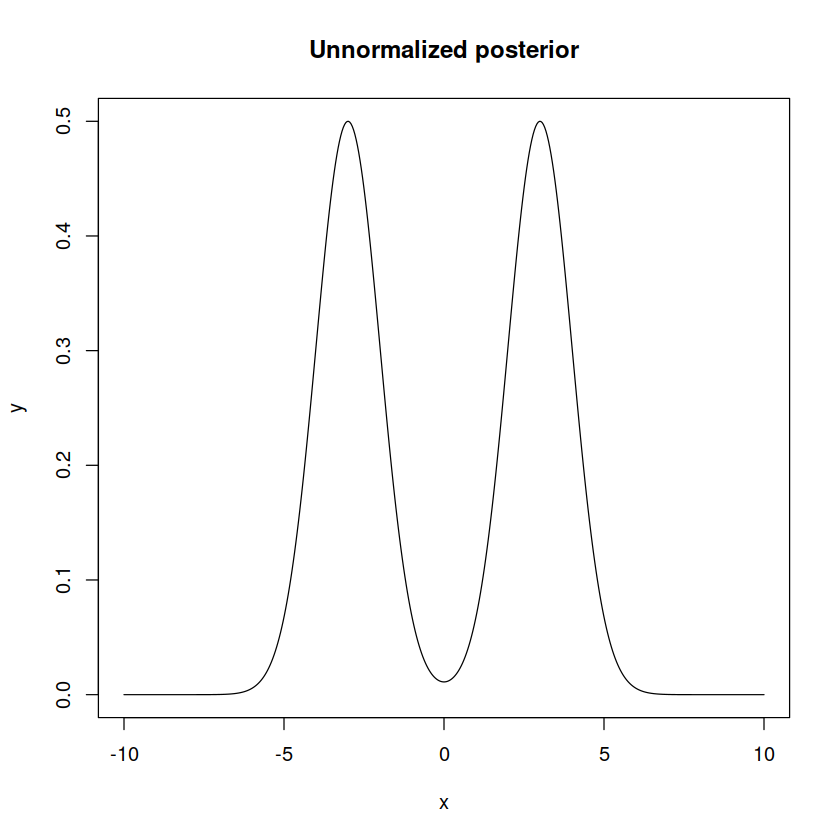

In [2]:
x = seq(from = -10, to = 10, length.out = 500)

myPost = function(x) {
    return(0.5 * exp(-(x + 3) ** 2 / 2) + 0.5 * exp(-(x - 3) ** 2 / 2))
}

y = myPost(x)

options(repr.plot.width=7, repr.plot.height=7)
plot(x, y, type = 'l', lty = 1, main = 'Unnormalized posterior')

Here we define the function for the Metropolis-Hasting algorithm, starting by the Professor's example on the course material. The code has been modified to include the fact that in this exercise an independent proposal density is required (i.e. Norm(0,1)). This implies that the Metropolis ratio has an extra factor that is not more equal to 1, as it was in the case of dependant symmetric proposal distribution.

In [3]:
testfunc_metropolis = function(theta) {
    return(log10(myPost(theta)))
}

metropolis_1dim = function(func, theta_init, n_sample, sigma) {
    theta_cur = theta_init
    func_cur = func(theta_cur)
    func_samp = matrix(data=NA, nrow=n_sample , ncol=2+1)
    n_accept = 0
    rate_accept = 0.0
    for (n in 1:n_sample) {
        theta_prop = rnorm(n=1, mean = 0, sd = sigma)
        func_prop = func(theta_prop)
        pdist_cur = log10(dnorm(theta_cur, mean = 0, sd = sigma))
        pdist_prop = log10(dnorm(theta_prop, mean = 0, sd = sigma))
        logMR = (func_prop + pdist_cur) - (func_cur + pdist_prop) # Log10 of the Metropolis-Hasting ratio
        if ((logMR >= 0) | (logMR > log10(runif(1)))) {
            theta_cur = theta_prop
            func_cur = func_prop
            n_accept = n_accept + 1
        }
        func_samp[n, 1] = func_cur
        func_samp[n, 2] = theta_cur
    }
    return(func_samp)
}

Here we run the M-H algorithm. Note that multiple $\sigma$ for the proposal distribution have been used, in order to have a better idea of the problem.

In [4]:
theta_init = 0
n_sample = 10 ** 5
sample_sig = c(0.36, 1.00, 4.00, 6.25, 16.00, 100.00)

chains = matrix(NA, nrow = n_sample, ncol = length(sample_sig))

i = 1
for (sig in sample_sig) {
    chains[,i] = metropolis_1dim(func=testfunc_metropolis, theta_init = theta_init, n_sample = n_sample, sigma = sig)[,2]
    i = i + 1
}

Here we plot the obtained chains. It is possible to notice that the first two values of $\sigma$ show zones in which the algorithm gets "stuck", probably because $\text{Norm}(0,\sigma)$ is too narrow with respect to the posterior and so there are regions in which a parameter has a low posterior PDF value and, at the same time, an high proposal PDF value, leading to a rejection of the new sample.

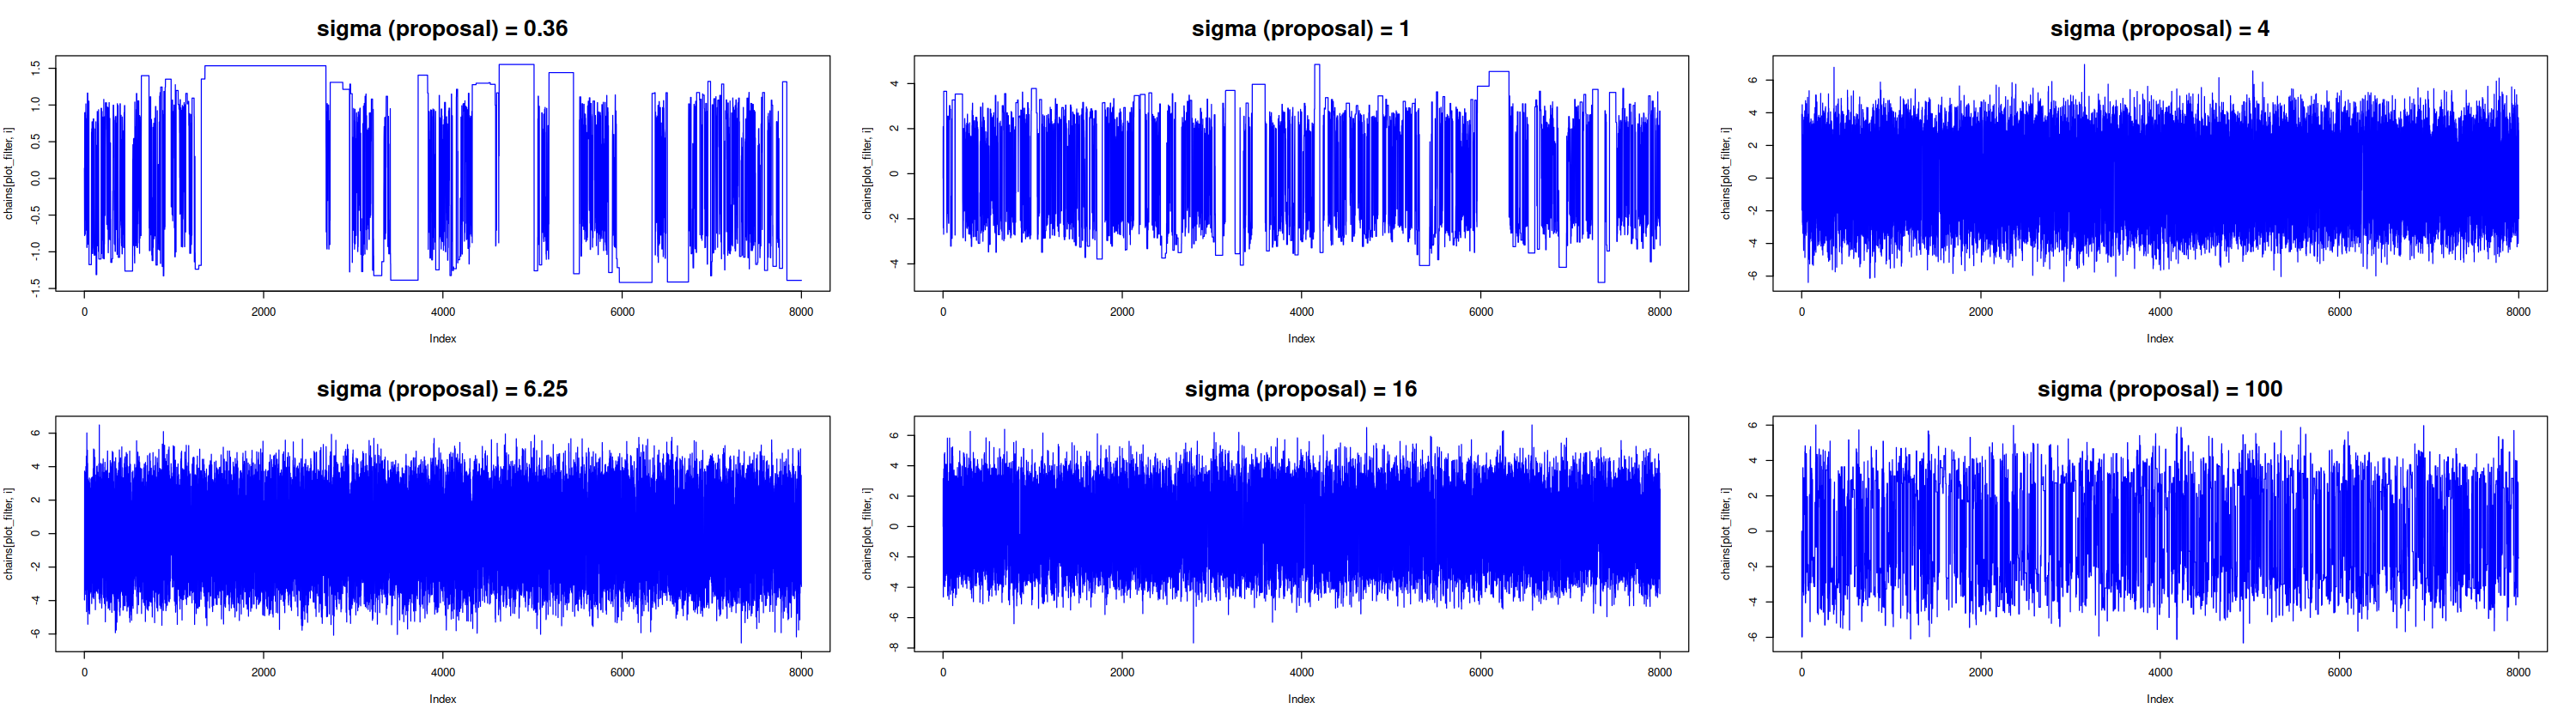

In [5]:
options(repr.plot.width=25, repr.plot.height=7)
par(mfrow=c(2,3))

plot_filter = seq(from = 1, to = nrow(chains), length.out = 8000) # thin to speed up the plot

cols = c('#2eaf17', '#8282c7', '#d95416', '#cc54dc', '#e0e015')
for (i in 1:ncol(chains)) {
    plot(chains[plot_filter,i], type = 'l', col = 'blue', main = paste('sigma (proposal) =', sample_sig[i]), cex.main = 2)
}

The fact mentioned above is evident also in this tiled plot, thanks to the presence of overcrowded bins.

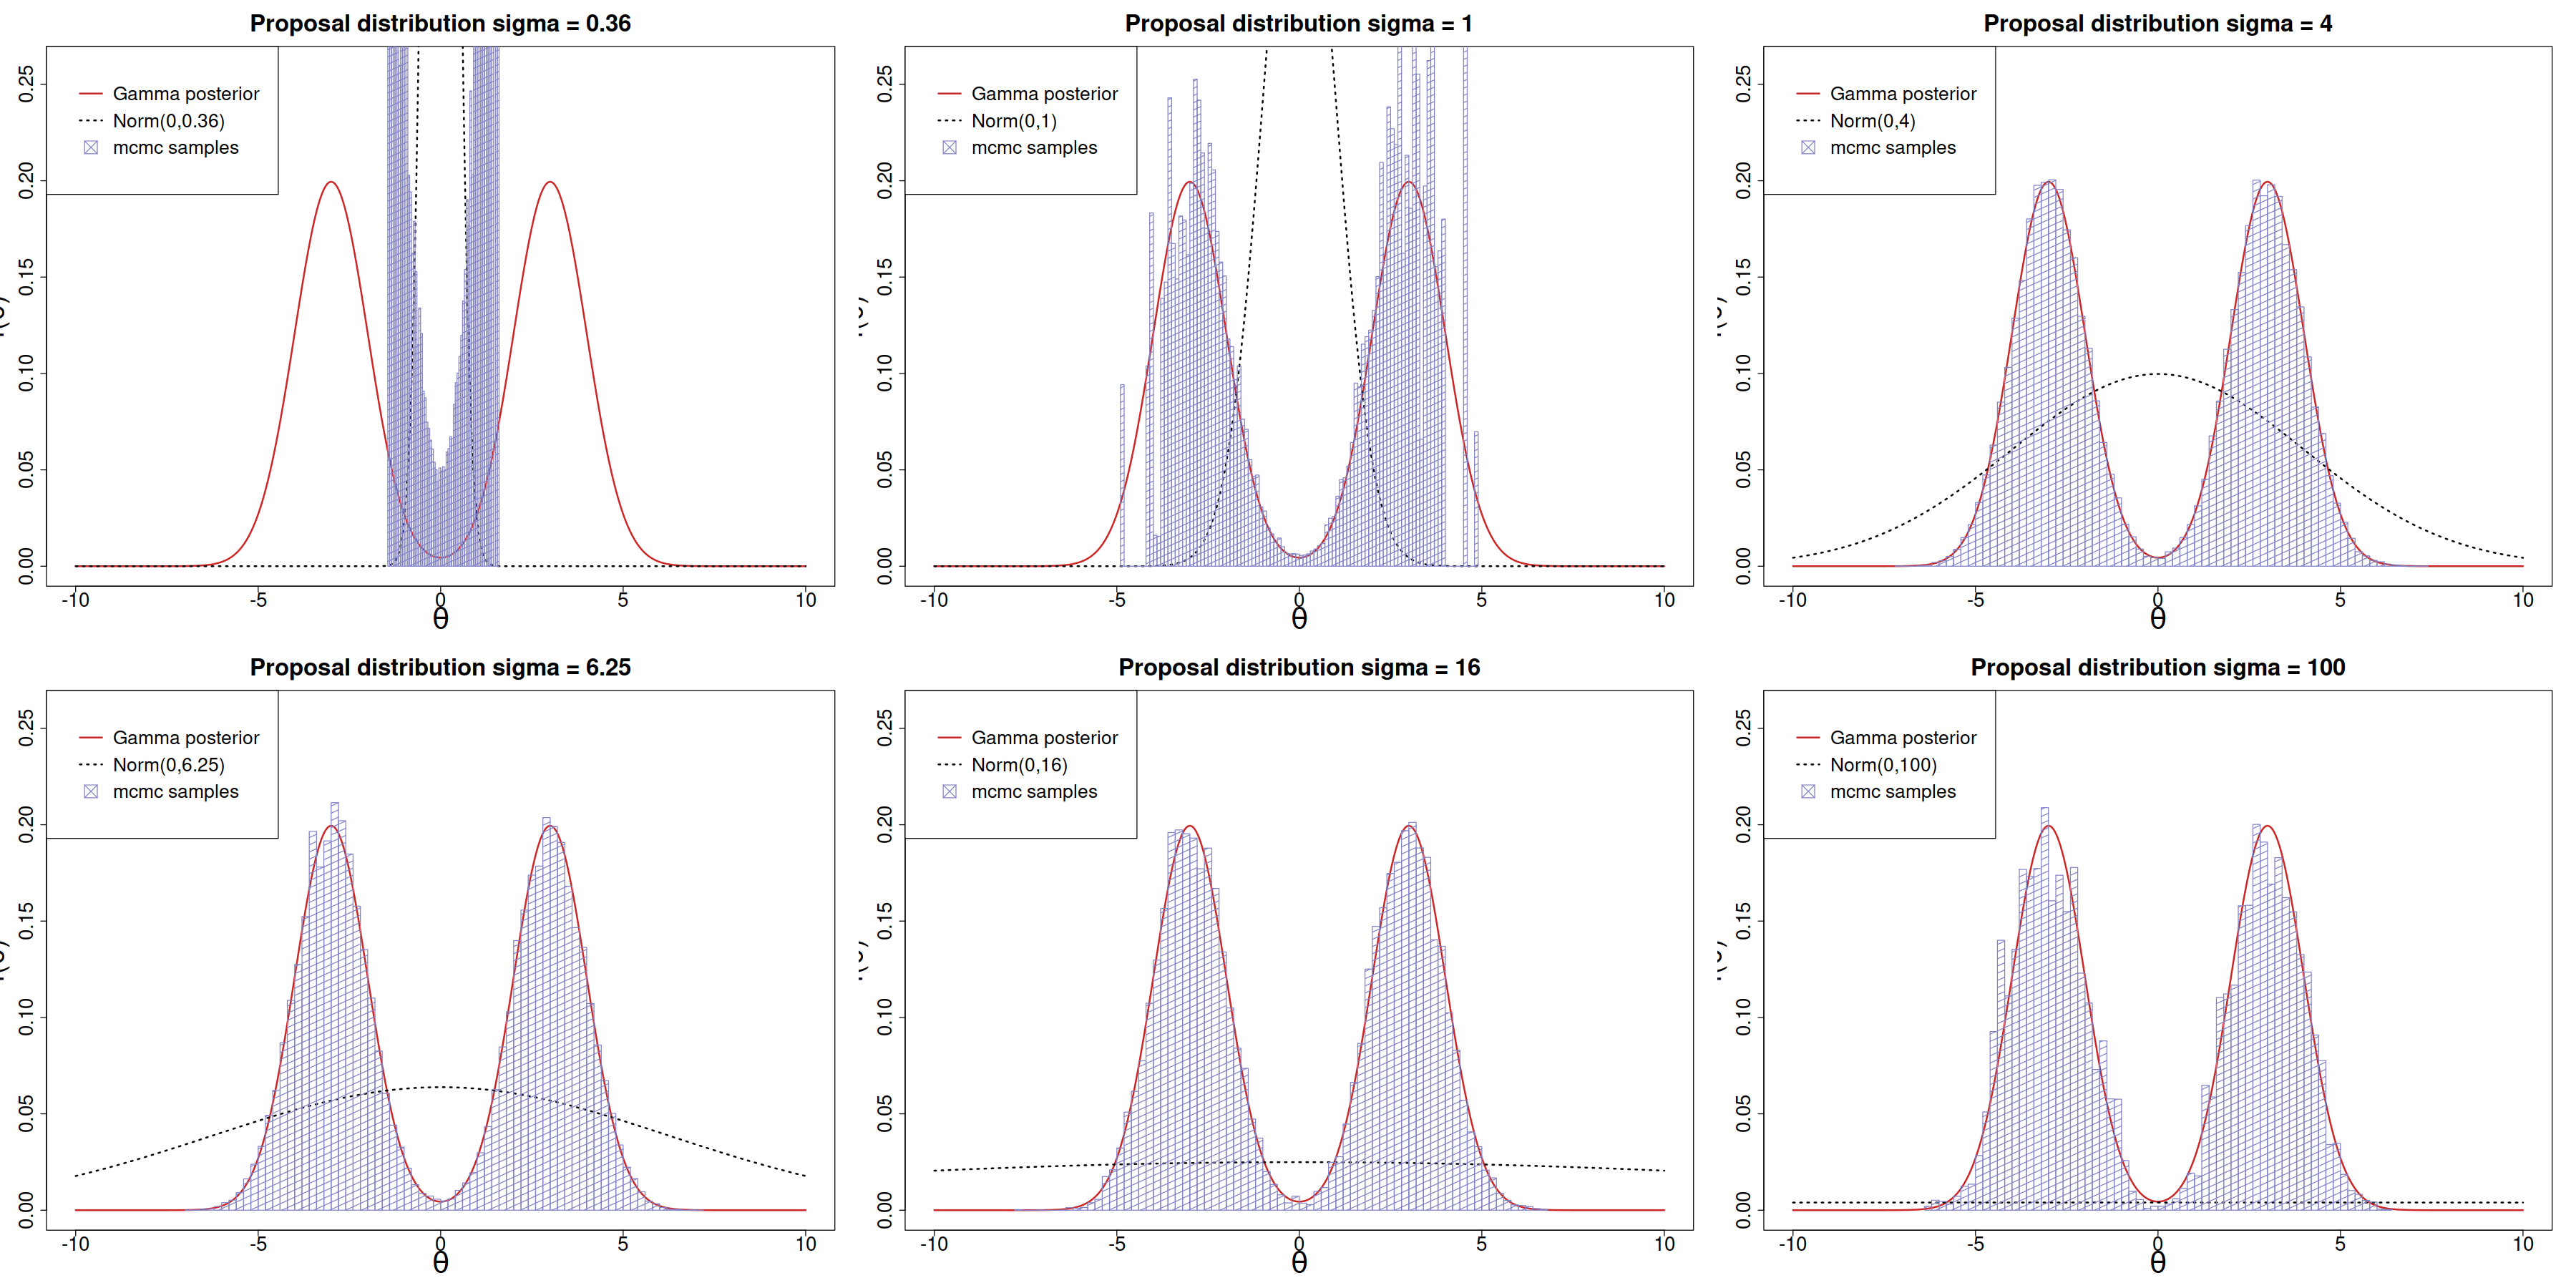

In [6]:
Z = sum(y) * (x[2] - x[1])
y_norm = y / Z

par(mfrow=c(2,3))
options(repr.plot.width=30, repr.plot.height=15)

cols = c('#2eaf17', '#8282c7', '#d95416', '#cc54dc', '#e0e015')
for (i in 1:ncol(chains)) {
    plot(x, y_norm, type='l', lwd=2, ylim = c(0, 1.3 * max(y_norm)), col='firebrick3', main = paste('Proposal distribution sigma =', sample_sig[i]),
        xlab=expression(theta), ylab=expression(paste('f(',theta ,')', sep='')), cex.axis = 2.1, cex.lab = 3, cex.main = 2.5)
    y_pdist = dnorm(x, mean = 0, sd = sample_sig[i])
    lines(x, y_pdist, type='l', lwd=2, lty = 3, col='black')
    hist(chains[,i], breaks = 70, freq = FALSE, density = 50, col = '#8282c7', add = TRUE)
    legend('topleft', legend = c('Gamma posterior', paste('Norm(0,', sample_sig[i], ')', sep = ''), 'mcmc samples'), col = c('firebrick3', 'black', '#8282c7'),
        lty = c(1, 3, NA), lwd = c(2, 2, NA), pch = c(NA, NA, 7), cex = 2, seg.len = 0.2, text.width = 3, x.intersp = 0.1, y.intersp = 0.4, pt.cex = 3)
}

The aforementioned observations are backed also by the study of the autocorrelation function (ACF) of the various chains. It is possible to notice that the two smallest $\sigma$ values lead to a small effective chain size. Instead $\sigma = 4$ leads to a significantly large effective chain size, as the ACF drops immediately to zero since the smaller lags.

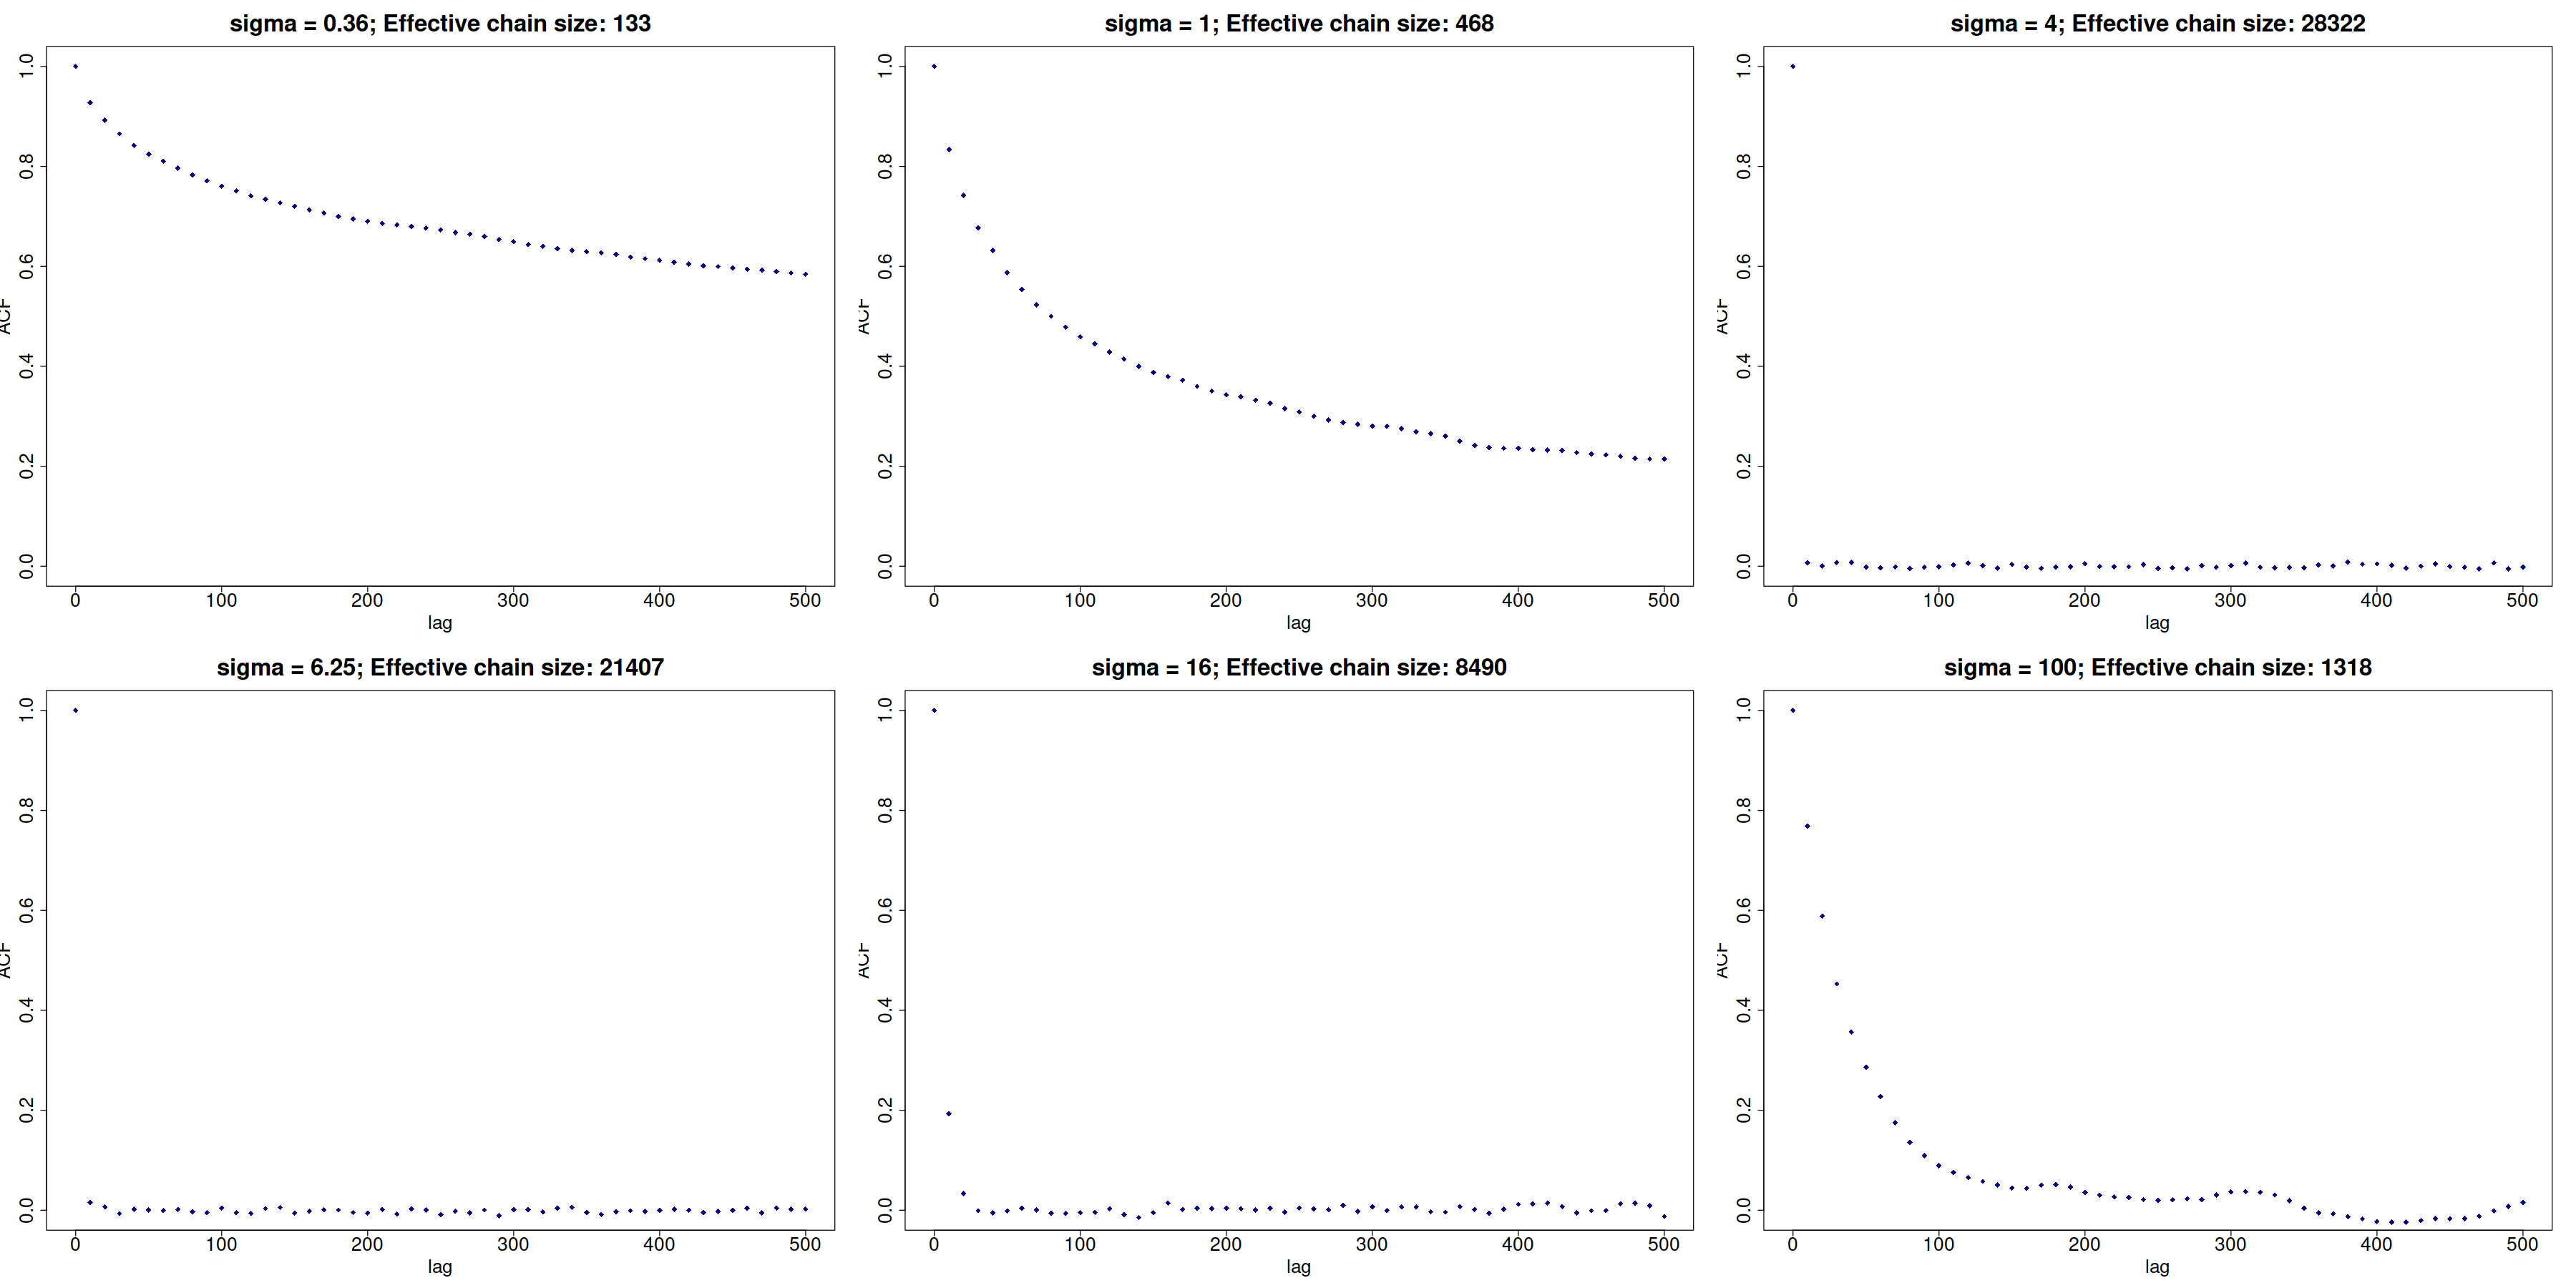

In [7]:
par(mfrow=c(2,3))
options(repr.plot.width=30, repr.plot.height=15)


lags = seq(0, 500, 10)
for (i in 1:ncol(chains)) {
    c_chain = as.mcmc(chains[,i])
    acf = autocorr(c_chain, lags=lags)
    plot(lags, acf, ylim=c(0,1), pch=18, col='navy', xlab='lag', ylab='ACF', cex=1.3, cex.axis = 2, cex.lab = 2, 
        main = paste('sigma = ', sample_sig[i], '; Effective chain size: ', as.integer(effectiveSize(c_chain)), sep = ''), cex.main = 2.5)
}

Here we focus on $\sigma = 1$ as required by the problem, and try to perform different thinnings of the chain, considering thinning factors in the range 1 - 30. It emerges that a thin factor of 24 guarantees the biggest reduction in the ACF keeping at the same time a discrete effective size. Bigger thinning factors would cause the effective chain size to become too small. <br>
Moreover introducing burn-in cycles would have the same effect without bringing much improvement. The overall conclusion is that the Norm(0,1) candidate pdf is not a good choice to sample from the considered posterior pdf. A distribution like Norm(0,4) could perform significantly better.

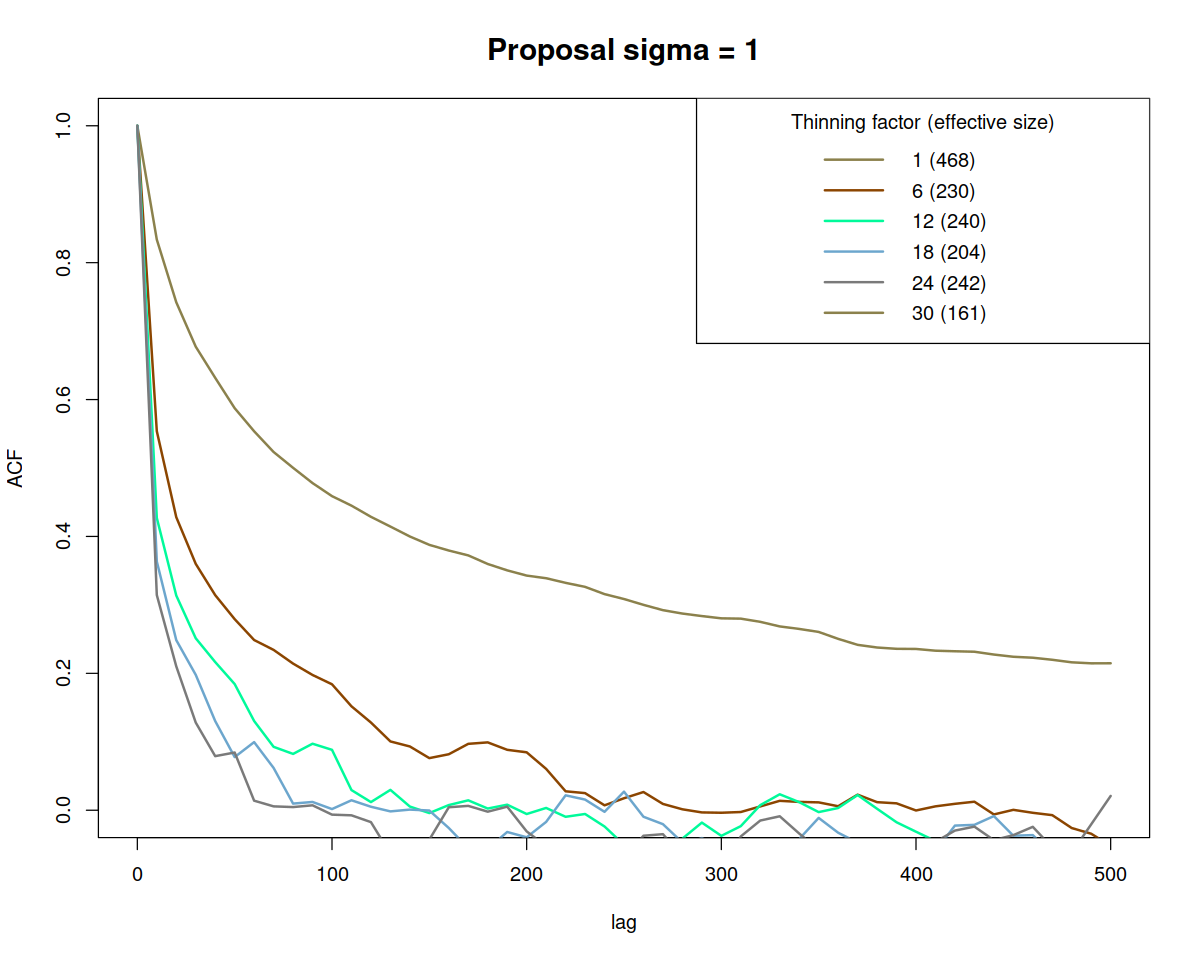

In [36]:
thin_factor = as.integer(seq(from = 1, to = 30, length.out = 6))

mycols = sample(colors(distinct = TRUE), 5)

options(repr.plot.width=10, repr.plot.height=8)

i = 2
chains_thinned = vector('list', length = length(thin_factor))
acfs = vector('list', length = length(thin_factor))
eff_sizes = rep(NA, length(thin_factor))
for (j in 1:length(thin_factor)) {
    thin = seq(from = 1, to = nrow(chains), by = thin_factor[j])
    chains_thinned[[j]] = chains[thin,i]
    c_chain = as.mcmc(na.omit(chains_thinned[[j]]))
    acfs[[j]] = autocorr(c_chain, lags)
    eff_sizes[j] = as.integer(effectiveSize(c_chain))
}

for (j in 1:length(thin_factor)) {
    if (j == 1) {
        plot(lags, acfs[[j]], type = 'l', ylim = c(0,1), col = mycols[j], xlab='lag', ylab='ACF', lwd = 2, cex=1.3, cex.axis = 1, cex.lab = 1, 
            main = paste('Proposal sigma = ', sample_sig[i], sep = ''), cex.main = 1.5) 
    } else {
        lines(lags, acfs[[j]], type = 'l', col = mycols[j], xlab='lag', ylab='ACF', lwd = 2, cex=1.3, cex.axis = 1, cex.lab = 1, 
            main = paste('Proposal sigma = ', sample_sig[i], sep = ''), cex.main = 1.5)   
    }
}

legend('topright', title = 'Thinning factor (effective size)', legend = paste(thin_factor, ' (', eff_sizes, ')', sep = ''), col = mycols, lwd = 2)

In this last plot we report histogram of the thinned chain.

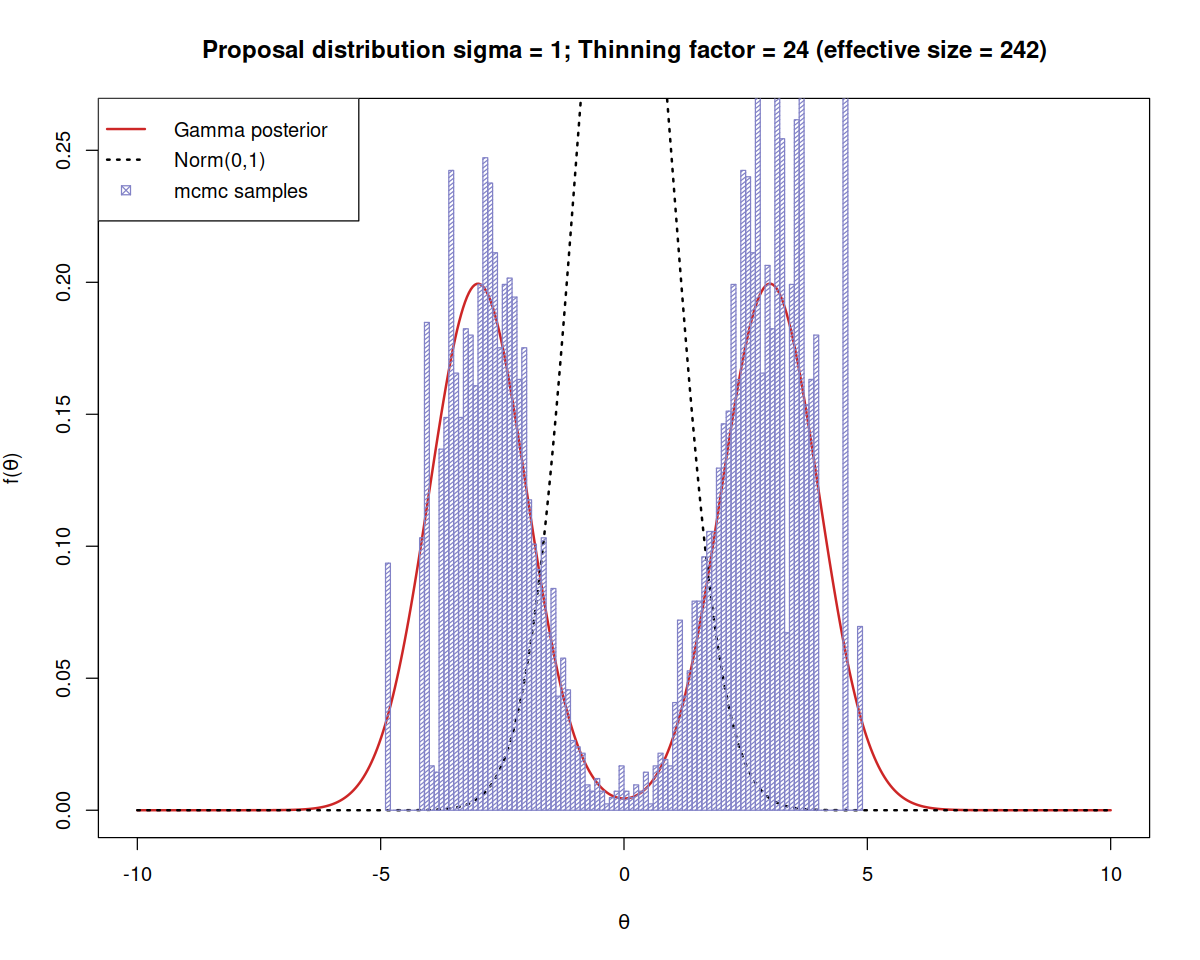

In [9]:
options(repr.plot.width=10, repr.plot.height = 8)

i = 2
j = 5

plot(x, y_norm, type='l', lwd=2, ylim = c(0, 1.3 * max(y_norm)), col='firebrick3', 
    main = paste('Proposal distribution sigma = ', sample_sig[i], '; Thinning factor = ', thin_factor[j], ' (effective size = ', eff_sizes[j], ')', sep = ''),
    xlab=expression(theta), ylab=expression(paste('f(',theta ,')', sep='')))
y_pdist = dnorm(x, mean = 0, sd = sample_sig[i])
lines(x, y_pdist, type='l', lwd=2, lty = 3, col='black')
hist(chains_thinned[[j]], breaks = 70, freq = FALSE, density = 50, col = '#8282c7', add = TRUE)
legend('topleft', legend = c('Gamma posterior', paste('Norm(0,', sample_sig[i], ')', sep = ''), 'mcmc samples'), col = c('firebrick3', 'black', '#8282c7'),
    lty = c(1, 3, NA), lwd = c(2, 2, NA), pch = c(NA, NA, 7), seg.len = 1.3, text.width = 3.5)

# Exercise 2

In this exercise we are going to perform a Bayesian inference about the efficacy of primary vaccination considering three vaccines that have been developed to face the spread of Covid-19 disease. The data used can be found in the website of the European Medicines Agency (EMA). 
<br>
<br>
The efficacy of a vaccine is measured considering a pool of pepple that is divided into two groups: each person takes either a dummy (placebo) shot or a vaccine shot according to the group of belonging. Then, considering the same time span, data about the arise of symptomatic Covid-19 infection in both groups is collected:
- Let $D$ be the percentage of people who took the dummy shot that contracted symptomatic Covid-19
- Let $V$ be the percentage of people who took the vaccine shot that contracted symptomatic Covid-19 

Then the efficacy is defined as:
$$
    \eta = \frac{D - V}{D} \qquad (1)
$$

Obviously it is expected that $D > V$ otherwise the vaccine would be harmful. Our workflow will be the following:
- infer the posterior PDF for $V$
- infer the posterior PDF for $D$
- estimate the posterior PDF for the efficacy $\eta$ using $(1)$, inferring thus the mode and the 95% credibility interval

The vaccines considered in this exercise are:
- Jcovden, produced by Janssen
- Spikevax, produced by Moderna
- Nuvaxoid, produced by Novavax

The comments reported for the code used for the analysis of Jcovden data hold also for all other vaccines, since the workflow is the same. 

## Jcovden by Janssen

In the following cell we create the variables with the data and two ```jags.model``` objects, one for inferring $V$ and the other for inferring $D$. The ```jags.model``` objects are build upon the ```model_vaccines.bug``` file, which includes a Binomial PDF for the likelihood and a Beta PDF as prior:

- the Binomial likelihood is due to the fact that the probability of getting a symptomatic Covid-19 infection both for a vaccinated and unvaccinated person can be modelized as a Bernoulli process, and since here we have multiple independent "trials" this leads to the Binomial distribution
- the prior is Beta(3, 100), as suggested by the Professor in the course material, which reflects our knowledge about how likely it is to be infected by Covid.
<!-- - the Beta priors are respectively Beta(0.9, 0.9) and Beta(5, 0.01). Both of them are well "distributed" around $\sim 10^{-3}$, which is approximately the same order of magnitude of the ratios ```y_vax``` / ```n_vax``` and ```y_placebo``` / ```n_placebo```, but Beta(0.9, 0.9) penalizes higher ratios because we expect the vaccine to be effective, while Beta(5, 0.01) penalizes lower ratios because we expect the unvaccinated people to me more at risk about contracting a symptomatic infection. -->

In [10]:
n_vax = 19630 # number of people who received the vaccine shot
y_vax = 116 # number of vaccinated pepole who developed Covid-19 infection with symptoms
n_placebo = 19691 # number of people who received the dummy shot
y_placebo = 348 # number of unvaccinated pepole who developed Covid-19 infection with symptoms

obs_vax = c(rep(1, y_vax), rep(0, n_vax - y_vax))
obs_placebo = c(rep(1, y_placebo), rep(0, n_placebo - y_placebo))

data = NULL
data$X = obs_vax
data$n = n_vax 

jm_vax = jags.model('model_vaccines.bug', data)

data = NULL
data$X = obs_placebo
data$n = n_placebo

jm_placebo = jags.model('model_vaccines.bug', data)

Warning message in jags.model("model_vaccines.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19630
   Unobserved stochastic nodes: 1
   Total graph size: 19633

Initializing model



Warning message in jags.model("model_vaccines.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19691
   Unobserved stochastic nodes: 1
   Total graph size: 19694

Initializing model



Here we let 1000 iterations of the chain as burn-in phase and then sample $10^4$ items from the chain using the ```coda.sample``` method, both for the $V$ and the $D$ chain.

In [11]:
update(jm_vax, 1000)
chain_vax = coda.samples(jm_vax, 'p', n.iter=10000)
results_vax = summary(chain_vax)
print(results_vax)

update(jm_placebo, 1000)
chain_placebo = coda.samples(jm_placebo, 'p', n.iter=10000)
results_placebo = summary(chain_placebo)
print(results_placebo)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     6.033e-03      5.500e-04      5.500e-06      5.590e-06 

2. Quantiles for each variable:

    2.5%      25%      50%      75%    97.5% 
0.004992 0.005660 0.006015 0.006391 0.007159 


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     1.772e-02      9.305e-04      9.305e-06      9.305e-06 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.01594 0.01709 0.01770 0.01833 0.01957 



Here we report the auto-generated plots for the chains of $V$ (blue) and $D$ (red).

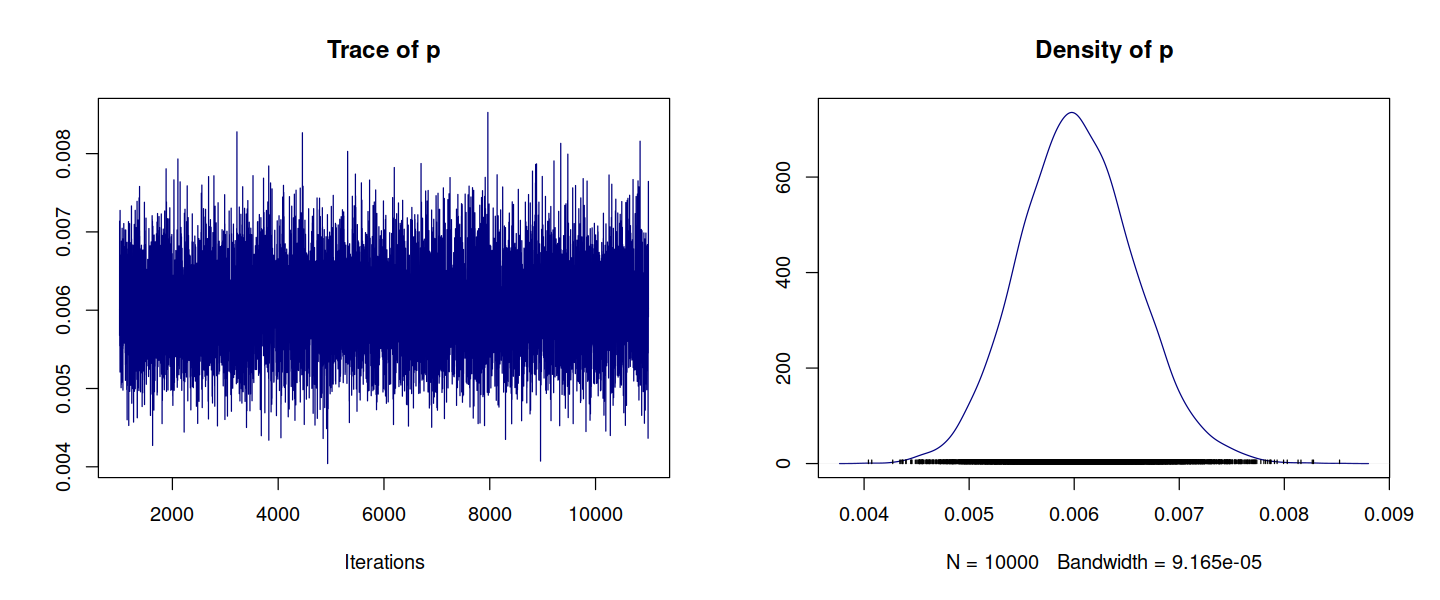

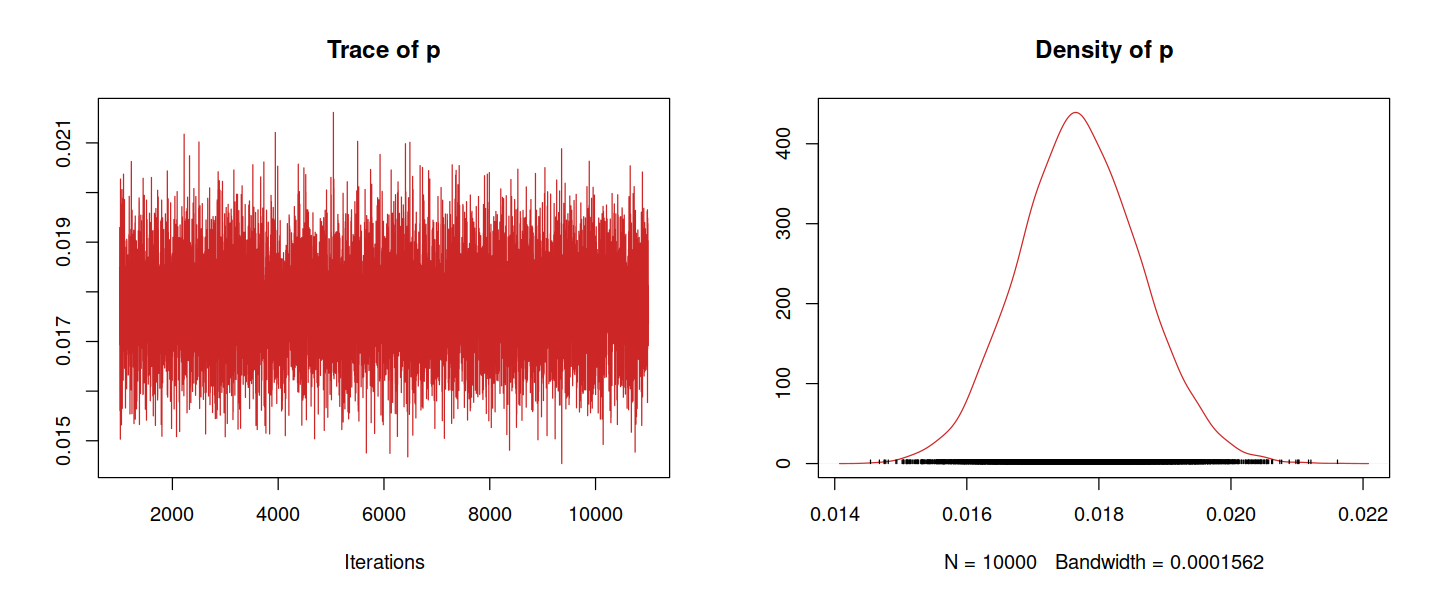

In [12]:
options(repr.plot.width=12, repr.plot.height=5)
plot(chain_vax, col="navy")
plot(chain_placebo, col="firebrick3")

Here we plot the histograms for the samples of $V$ and $D$ and finally we build the histrogram for $\eta$ using formula $(1)$.

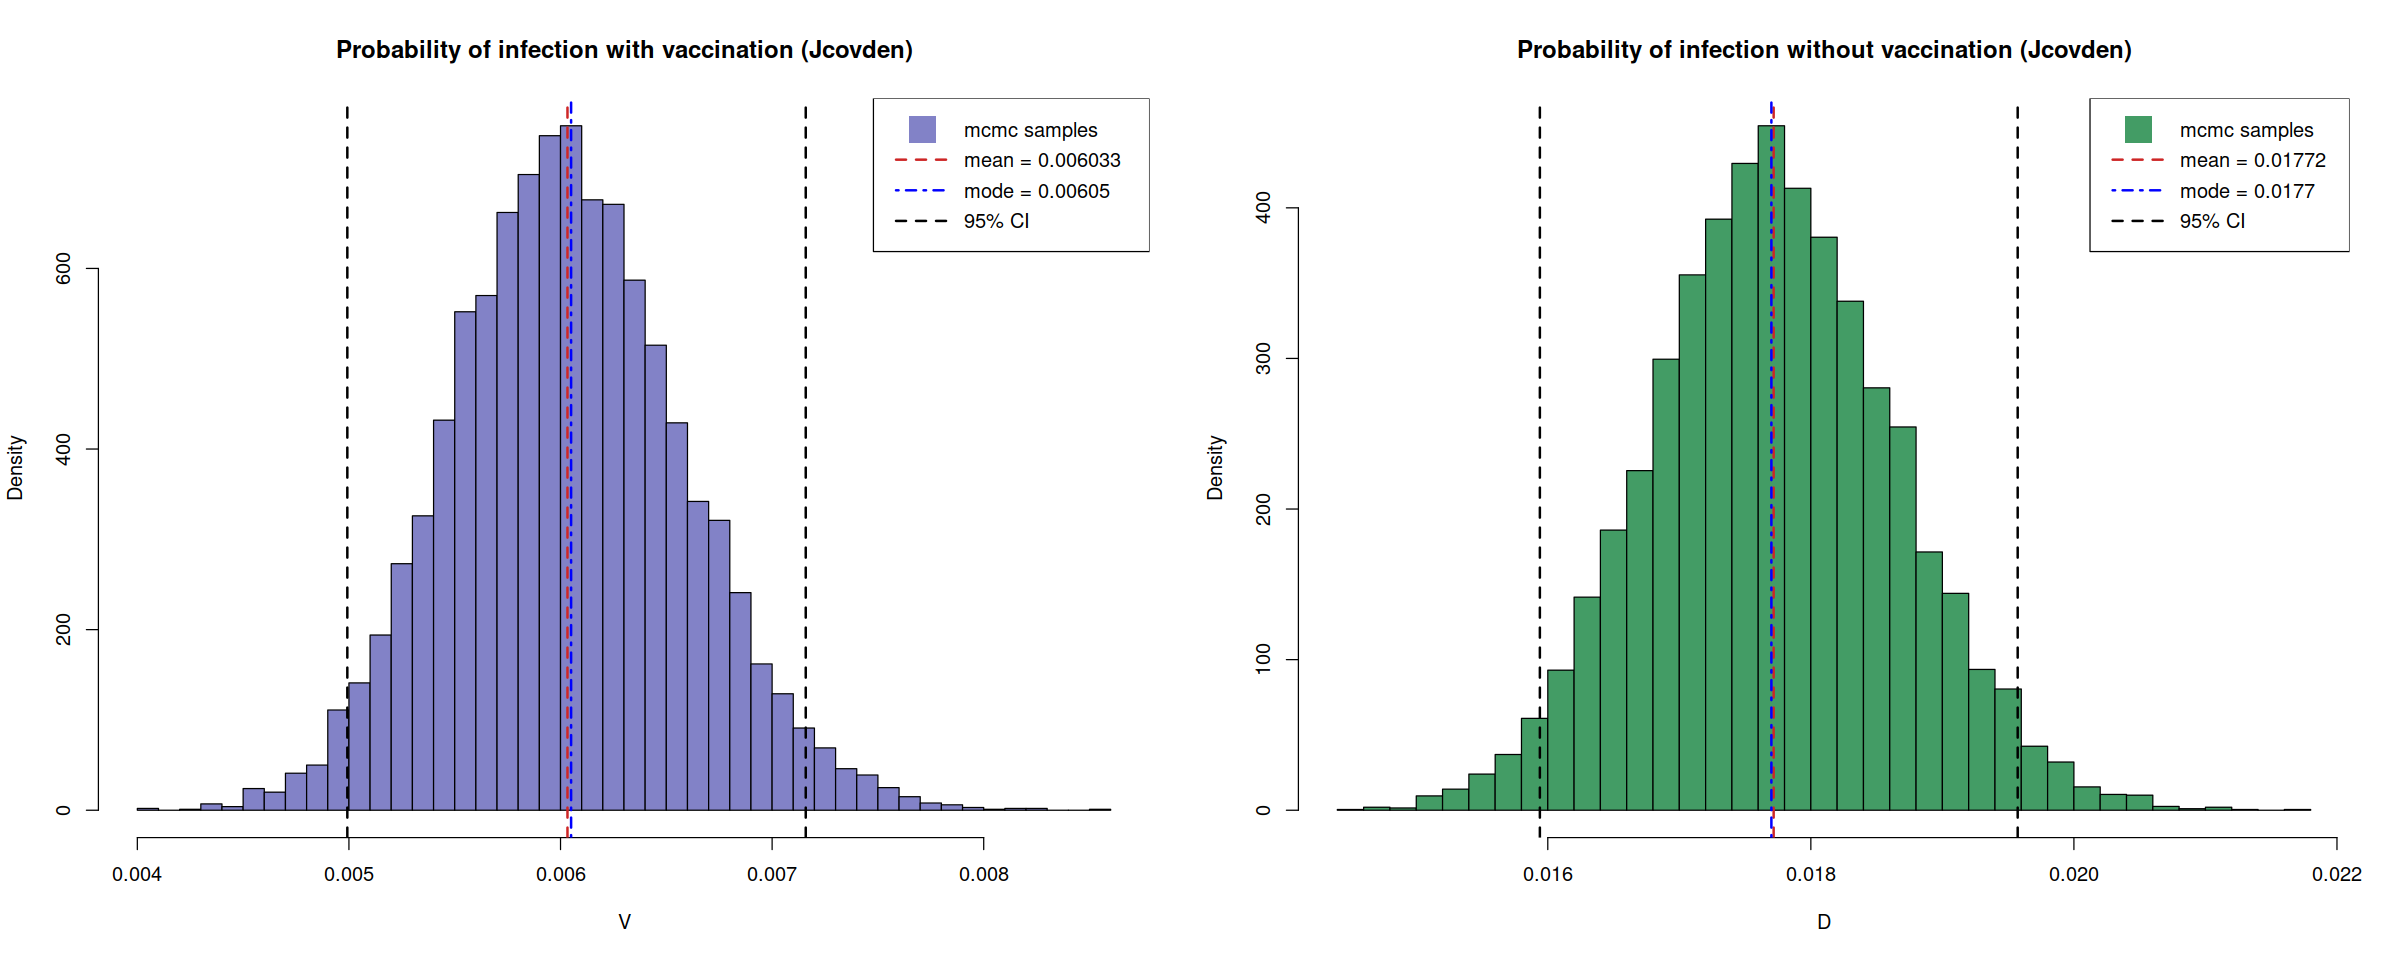

mean      median   mode   CI95_low CI95_high
1 0.6585332 0.660164 0.6625 0.582844 0.7246196

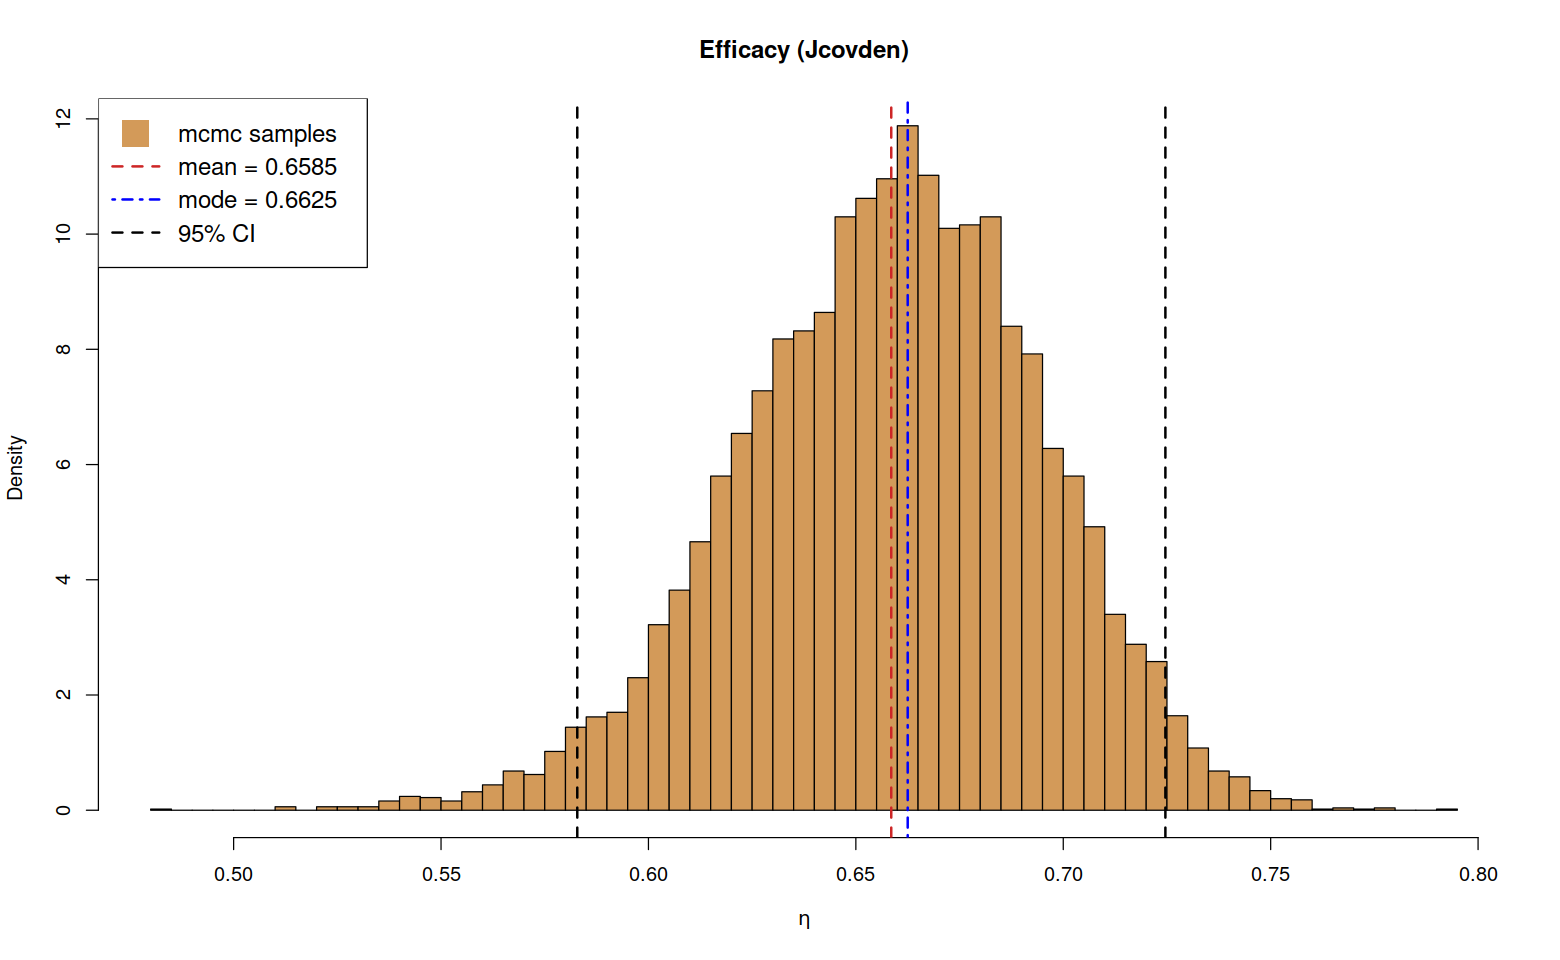

In [13]:
chain_tbl = as_tibble(as.mcmc(chain_vax))
chain_tbl = chain_tbl %>% 
        rename(p_vax = 1) %>% 
        mutate(p_placebo = as.double(as.mcmc(chain_placebo))) %>% 
        mutate(p_eff = (p_placebo - p_vax) / p_placebo)

# p histogram = p posterior
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow = c(1,2))

h = hist(chain_tbl$p_vax, breaks = 'Scott', freq = FALSE, col = '#8282c7', xlab = 'V',
        main = 'Probability of infection with vaccination (Jcovden)')
abline(v = results_vax$statistics['Mean'], col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(results_vax$quantiles['2.5%'], results_vax$quantiles['97.5%']), col = 'black', lty = 2, lwd = 2)
legend('topright', legend = c('mcmc samples', paste('mean =', format(results_vax$statistics['Mean'], digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#8282c7', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), text.width = 0.0007, seg.len = 0.7, x.intersp = 0.2, pt.cex = 3)

h = hist(chain_tbl$p_placebo, breaks = 'Scott', freq = FALSE, col = '#439c65', xlab = 'D',
        main = 'Probability of infection without vaccination (Jcovden)')
abline(v = results_placebo$statistics['Mean'], col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(results_placebo$quantiles['2.5%'], results_placebo$quantiles['97.5%']), col = 'black', lty = 2, lwd = 2)
legend('topright', legend = c('mcmc samples', paste('mean =', format(results_placebo$statistics['Mean'], digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#439c65', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), text.width = 0.001, seg.len = 0.7, x.intersp = 0.2, pt.cex = 3)

options(repr.plot.width=13, repr.plot.height=8)
par(mfrow = c(1,1))
h = hist(chain_tbl$p_eff, breaks = 'Freedman-Diaconis', freq = FALSE, col = '#d39a59', xlab = expression(eta),
        main = 'Efficacy (Jcovden)')
abline(v = mean(chain_tbl$p_eff), col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(unname(quantile(chain_tbl$p_eff, 0.025)), unname(quantile(chain_tbl$p_eff, 0.975))), col = 'black', lty = 2, lwd = 2)
legend('topleft', legend = c('mcmc samples', paste('mean =', format(mean(chain_tbl$p_eff), digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#d39a59', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), cex = 1.2, seg.len = 1, text.width = 0.04, x.intersp = 0.4, y.intersp = 0.9, pt.cex = 3)

efficacy_tbl = chain_tbl %>% 
        select(p_eff) %>% 
        summarise(mean = mean(p_eff), 
                median = median(p_eff), 
                mode = mode, 
                CI95_low = unname(quantile(p_eff, 0.025)), 
                CI95_high = unname(quantile(p_eff, 0.975)))
efficacy_tbl

## Spikevax by Moderna

In [14]:
n_vax = 14134
y_vax = 11 
n_placebo = 14073
y_placebo = 185

obs_vax = c(rep(1, y_vax), rep(0, n_vax - y_vax))
obs_placebo = c(rep(1, y_placebo), rep(0, n_placebo - y_placebo))

data = NULL
data$X = obs_vax
data$n = n_vax 

jm_vax = jags.model('model_vaccines.bug', data)

data = NULL
data$X = obs_placebo
data$n = n_placebo

jm_placebo = jags.model('model_vaccines.bug', data)

Warning message in jags.model("model_vaccines.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 14134
   Unobserved stochastic nodes: 1
   Total graph size: 14137

Initializing model



Warning message in jags.model("model_vaccines.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 14073
   Unobserved stochastic nodes: 1
   Total graph size: 14076

Initializing model



In [15]:
update(jm_vax, 1000)
chain_vax = coda.samples(jm_vax, 'p', n.iter=10000)
results_vax = summary(chain_vax)
print(results_vax)

update(jm_placebo, 1000)
chain_placebo = coda.samples(jm_placebo, 'p', n.iter=10000)
results_placebo = summary(chain_placebo)
print(results_placebo)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      9.84e-04       2.63e-04       2.63e-06       2.63e-06 

2. Quantiles for each variable:

     2.5%       25%       50%       75%     97.5% 
0.0005351 0.0007978 0.0009657 0.0011443 0.0015570 


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     1.327e-02      9.519e-04      9.519e-06      9.519e-06 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.01149 0.01262 0.01324 0.01390 0.01523 



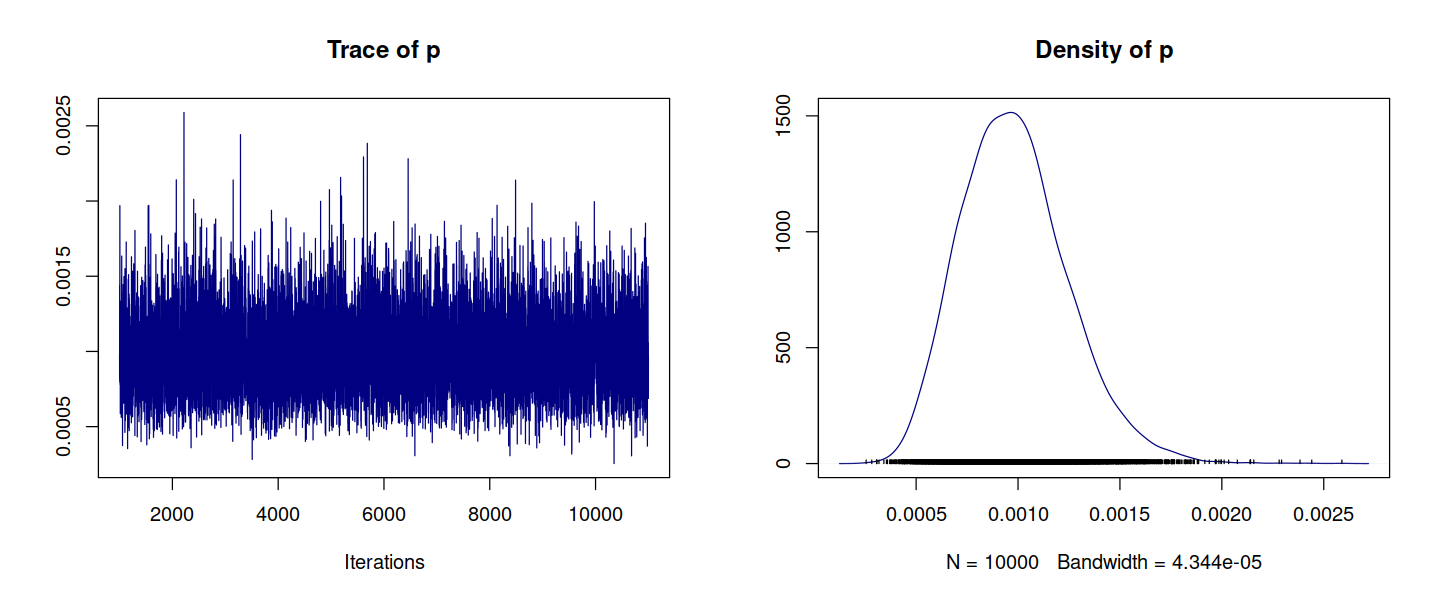

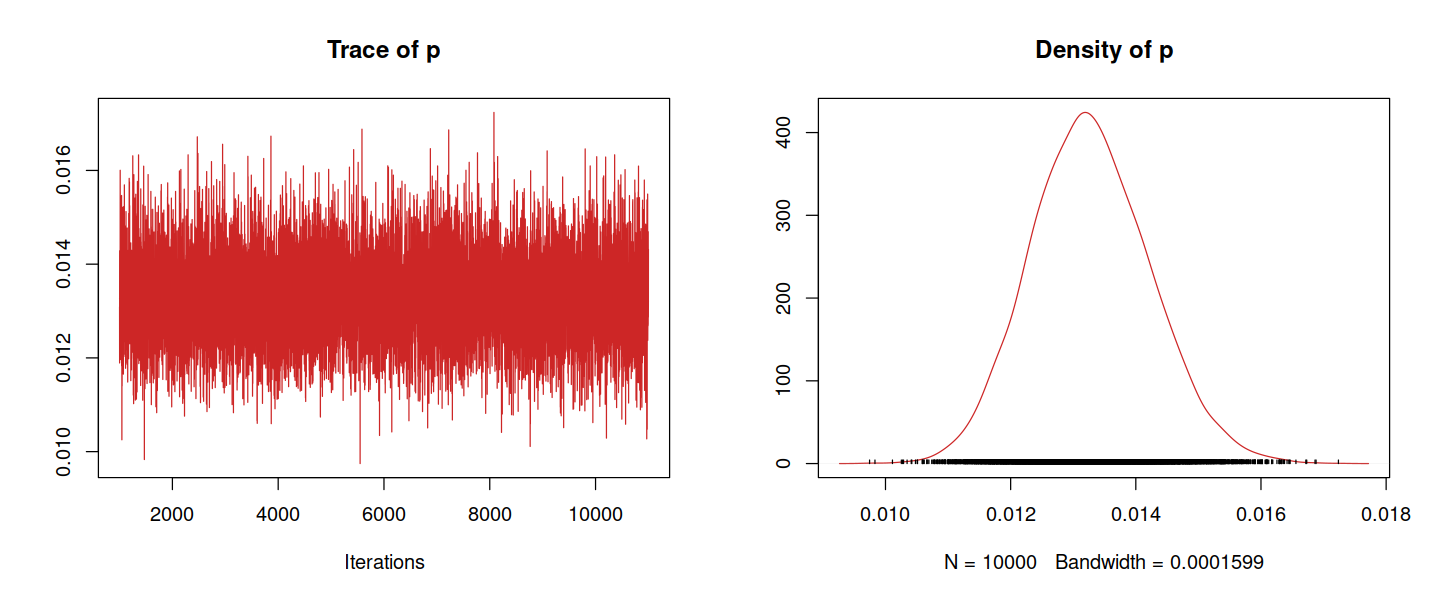

In [16]:
options(repr.plot.width=12, repr.plot.height=5)
plot(chain_vax, col="navy")
plot(chain_placebo, col="firebrick3")

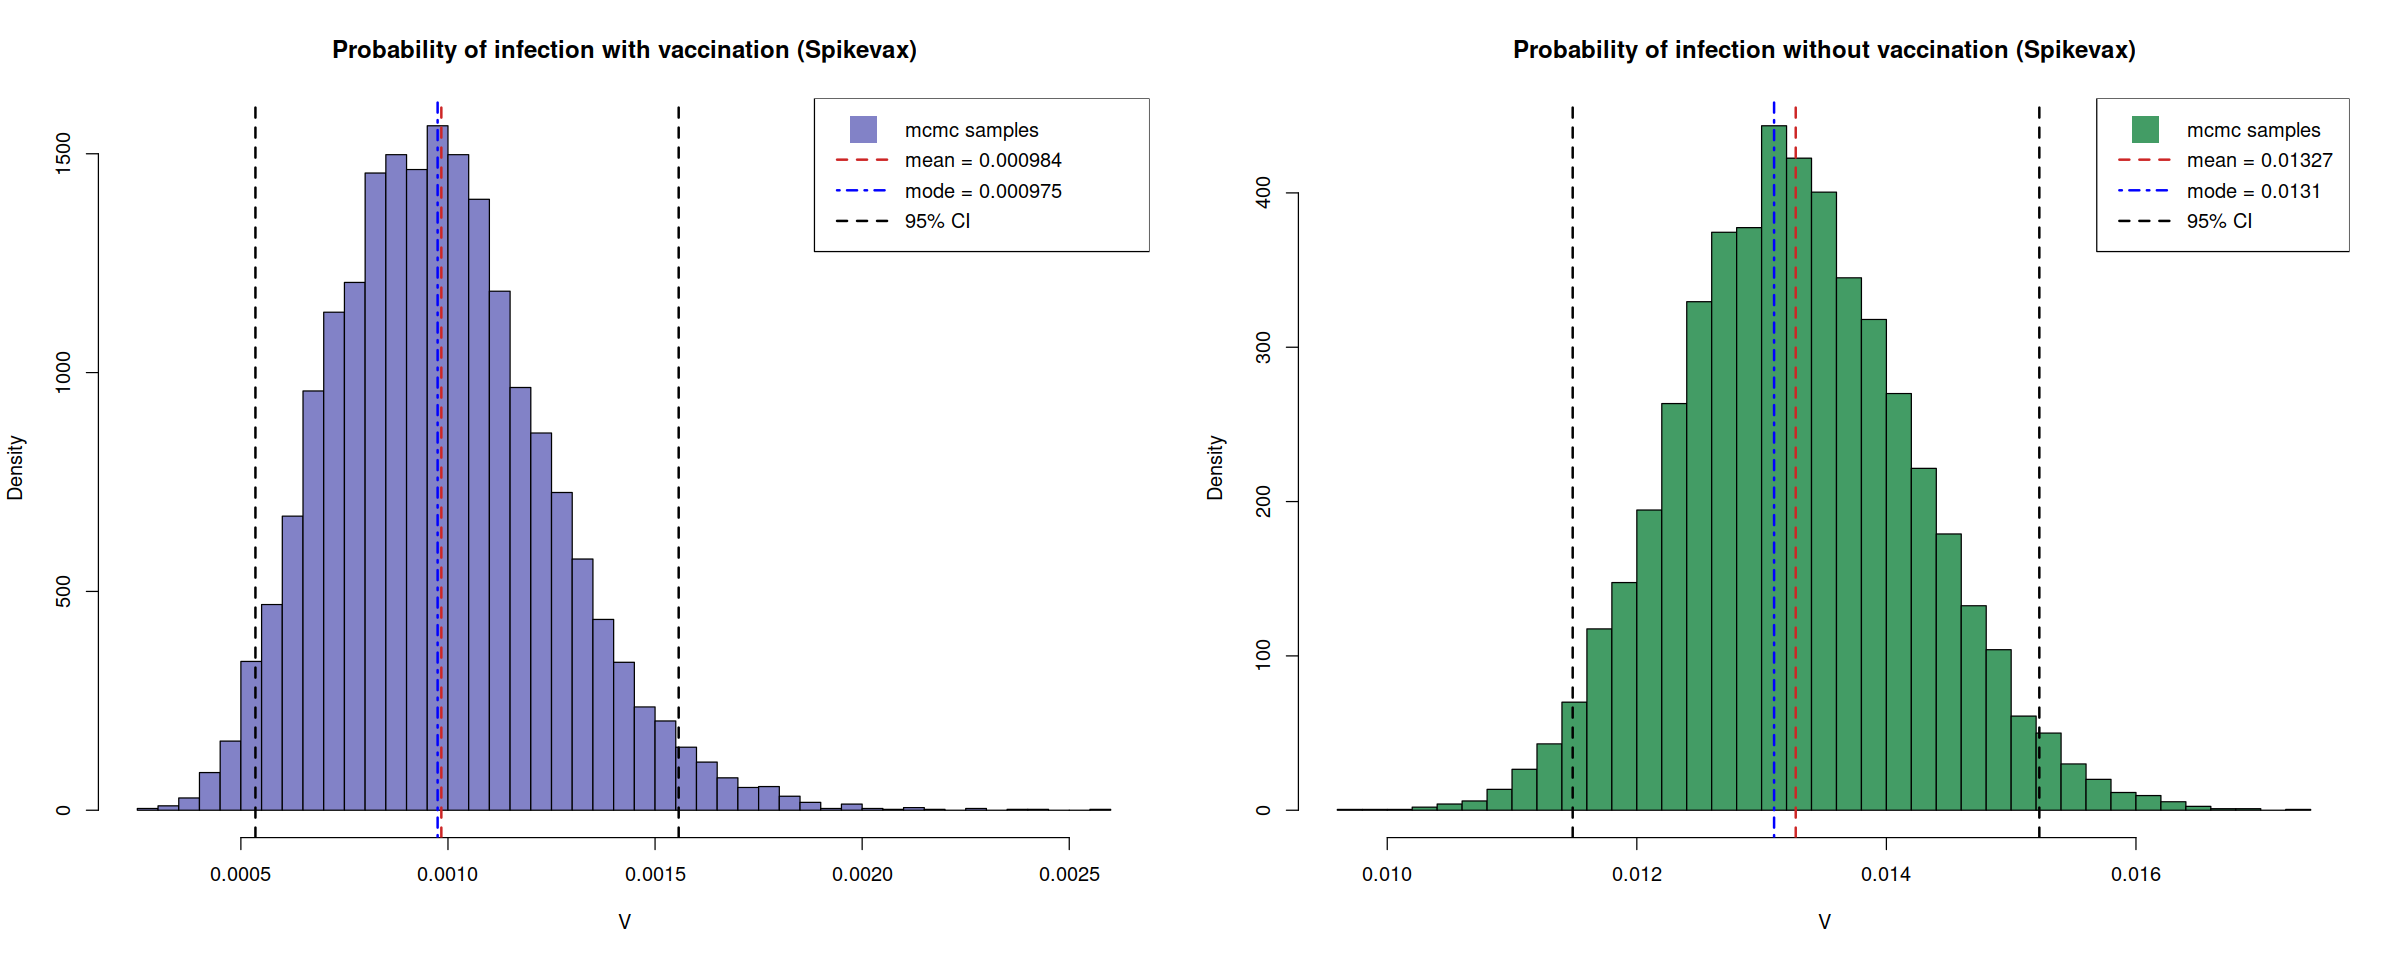

mean      median    mode  CI95_low  CI95_high
1 0.9254935 0.9273963 0.935 0.8811324 0.9600597

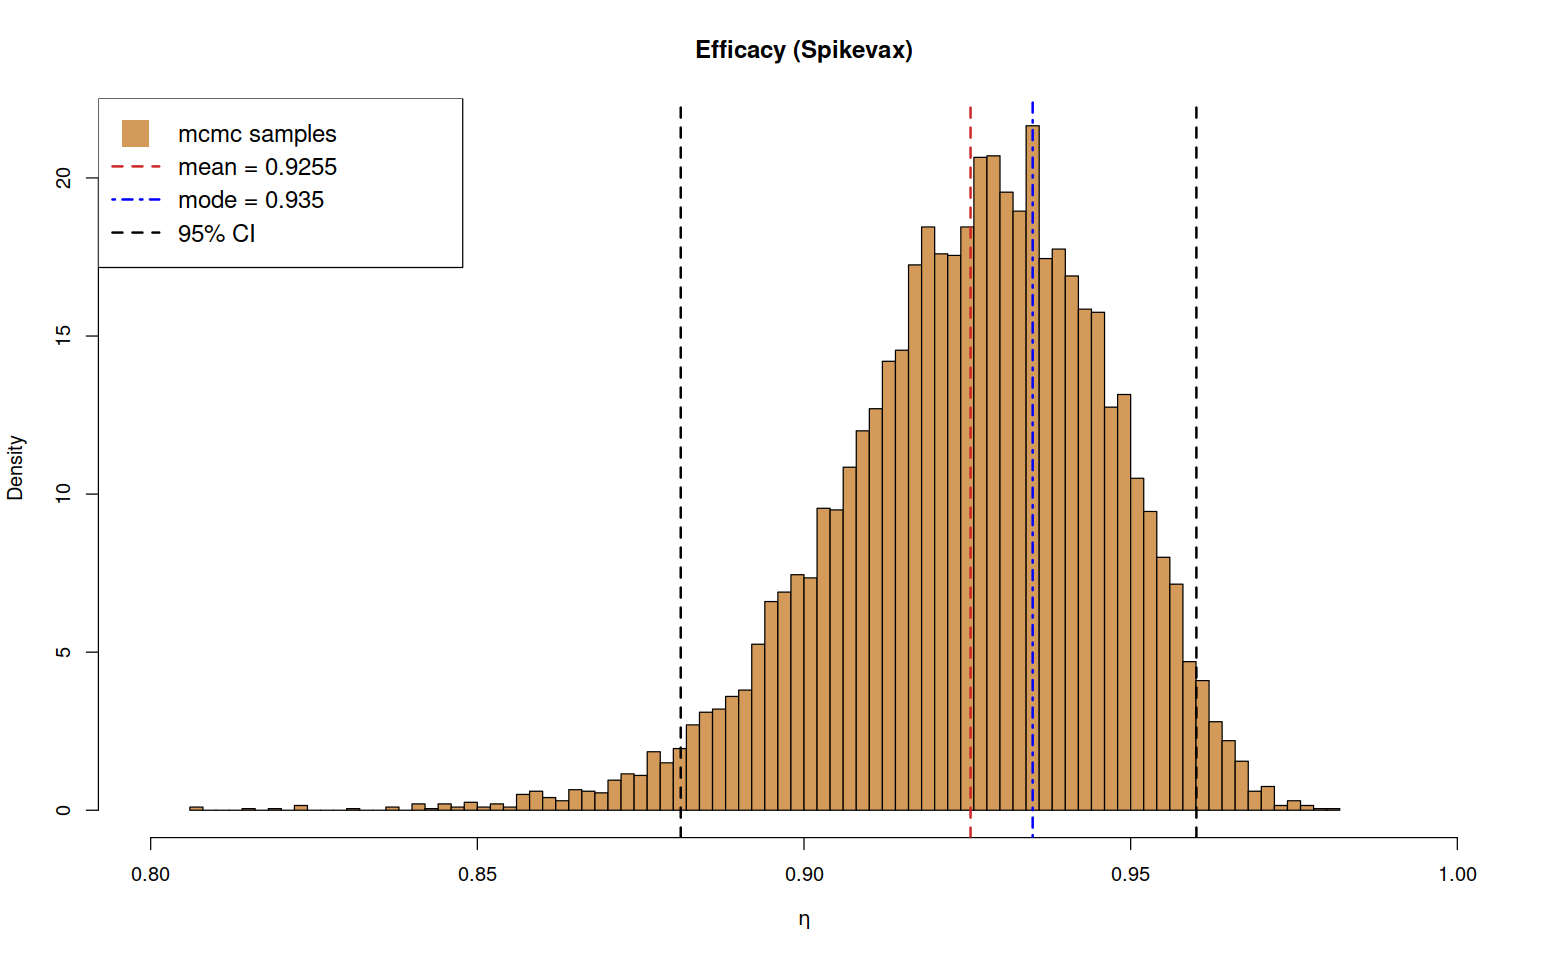

In [17]:
chain_tbl = as_tibble(as.mcmc(chain_vax))
chain_tbl = chain_tbl %>% 
        rename(p_vax = 1) %>% 
        mutate(p_placebo = as.double(as.mcmc(chain_placebo))) %>% 
        mutate(p_eff = (p_placebo - p_vax) / p_placebo)

# p histogram = p posterior
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow = c(1,2))

h = hist(chain_tbl$p_vax, breaks = 'Scott', freq = FALSE, col = '#8282c7', xlab = 'V',
        main = 'Probability of infection with vaccination (Spikevax)')
abline(v = results_vax$statistics['Mean'], col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(results_vax$quantiles['2.5%'], results_vax$quantiles['97.5%']), col = 'black', lty = 2, lwd = 2)
legend('topright', legend = c('mcmc samples', paste('mean =', format(results_vax$statistics['Mean'], digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#8282c7', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), text.width = 0.0005, seg.len = 0.7, x.intersp = 0.2, pt.cex = 3)

h = hist(chain_tbl$p_placebo, breaks = 'Scott', freq = FALSE, col = '#439c65', xlab = 'V',
        main = 'Probability of infection without vaccination (Spikevax)')
abline(v = results_placebo$statistics['Mean'], col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(results_placebo$quantiles['2.5%'], results_placebo$quantiles['97.5%']), col = 'black', lty = 2, lwd = 2)
legend('topright', legend = c('mcmc samples', paste('mean =', format(results_placebo$statistics['Mean'], digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#439c65', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), text.width = 0.001, seg.len = 0.7, x.intersp = 0.2, pt.cex = 3)

options(repr.plot.width=13, repr.plot.height=8)
par(mfrow = c(1,1))
h = hist(chain_tbl$p_eff, breaks = 'Freedman-Diaconis', freq = FALSE, col = '#d39a59', xlab = expression(eta),
        main = 'Efficacy (Spikevax)', xlim = c(0.80, 1))
abline(v = mean(chain_tbl$p_eff), col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(unname(quantile(chain_tbl$p_eff, 0.025)), unname(quantile(chain_tbl$p_eff, 0.975))), col = 'black', lty = 2, lwd = 2)
legend('topleft', legend = c('mcmc samples', paste('mean =', format(mean(chain_tbl$p_eff), digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#d39a59', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), cex = 1.2, seg.len = 1, text.width = 0.04, x.intersp = 0.4, y.intersp = 0.9, pt.cex = 3)

efficacy_tbl = chain_tbl %>% 
        select(p_eff) %>% 
        summarise(mean = mean(p_eff), 
                median = median(p_eff), 
                mode = mode, 
                CI95_low = unname(quantile(p_eff, 0.025)), 
                CI95_high = unname(quantile(p_eff, 0.975)))
efficacy_tbl

## Nuvaxoid by Novavax

In [18]:
n_vax = 17312
y_vax = 14 
n_placebo = 8140
y_placebo = 63

obs_vax = c(rep(1, y_vax), rep(0, n_vax - y_vax))
obs_placebo = c(rep(1, y_placebo), rep(0, n_placebo - y_placebo))

data = NULL
data$X = obs_vax
data$n = n_vax 

jm_vax = jags.model('model_vaccines.bug', data)

data = NULL
data$X = obs_placebo
data$n = n_placebo

jm_placebo = jags.model('model_vaccines.bug', data)

Warning message in jags.model("model_vaccines.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 17312
   Unobserved stochastic nodes: 1
   Total graph size: 17315

Initializing model



Warning message in jags.model("model_vaccines.bug", data):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8140
   Unobserved stochastic nodes: 1
   Total graph size: 8143

Initializing model



In [19]:
update(jm_vax, 1000)
chain_vax = coda.samples(jm_vax, 'p', n.iter=10000)
results_vax = summary(chain_vax)
print(results_vax)

update(jm_placebo, 1000)
chain_placebo = coda.samples(jm_placebo, 'p', n.iter=10000)
results_placebo = summary(chain_placebo)
print(results_placebo)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     9.785e-04      2.385e-04      2.385e-06      2.385e-06 

2. Quantiles for each variable:

     2.5%       25%       50%       75%     97.5% 
0.0005736 0.0008084 0.0009576 0.0011291 0.0014929 


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     8.022e-03      9.840e-04      9.840e-06      9.840e-06 

2. Quantiles for each variable:

    2.5%      25%      50%      75%    97.5% 
0.006166 0.007346 0.007982 0.008643 0.010034 



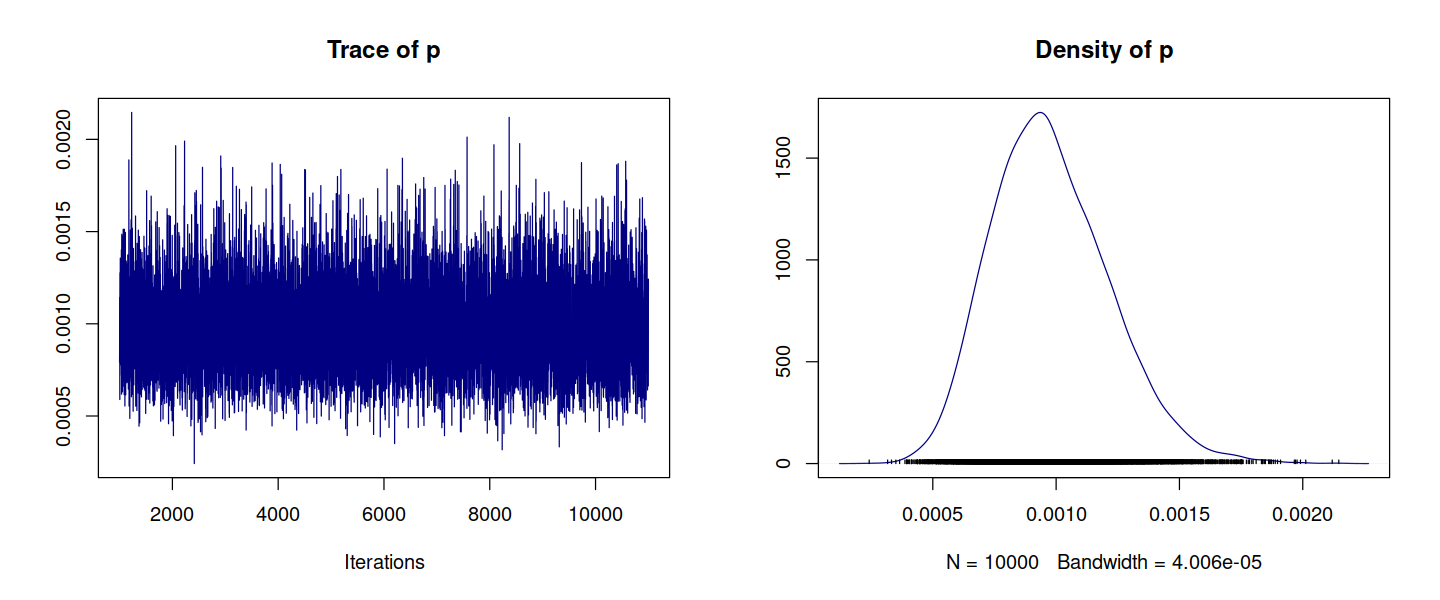

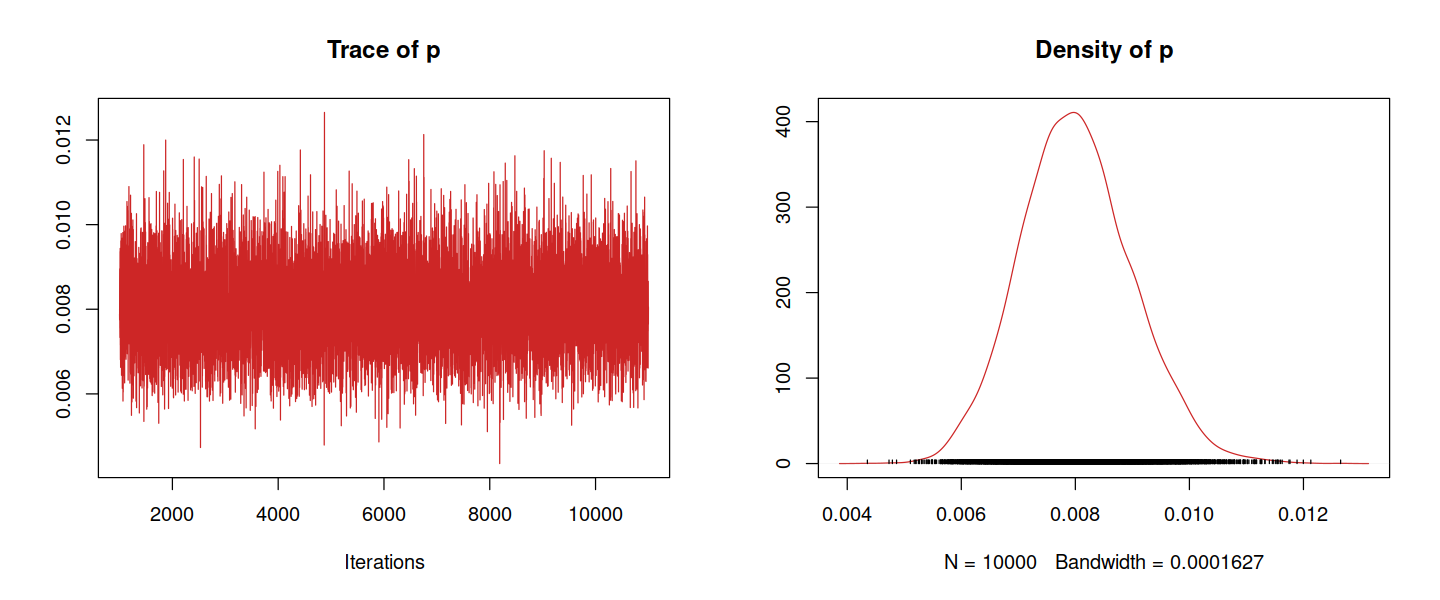

In [20]:
options(repr.plot.width=12, repr.plot.height=5)
plot(chain_vax, col="navy")
plot(chain_placebo, col="firebrick3")

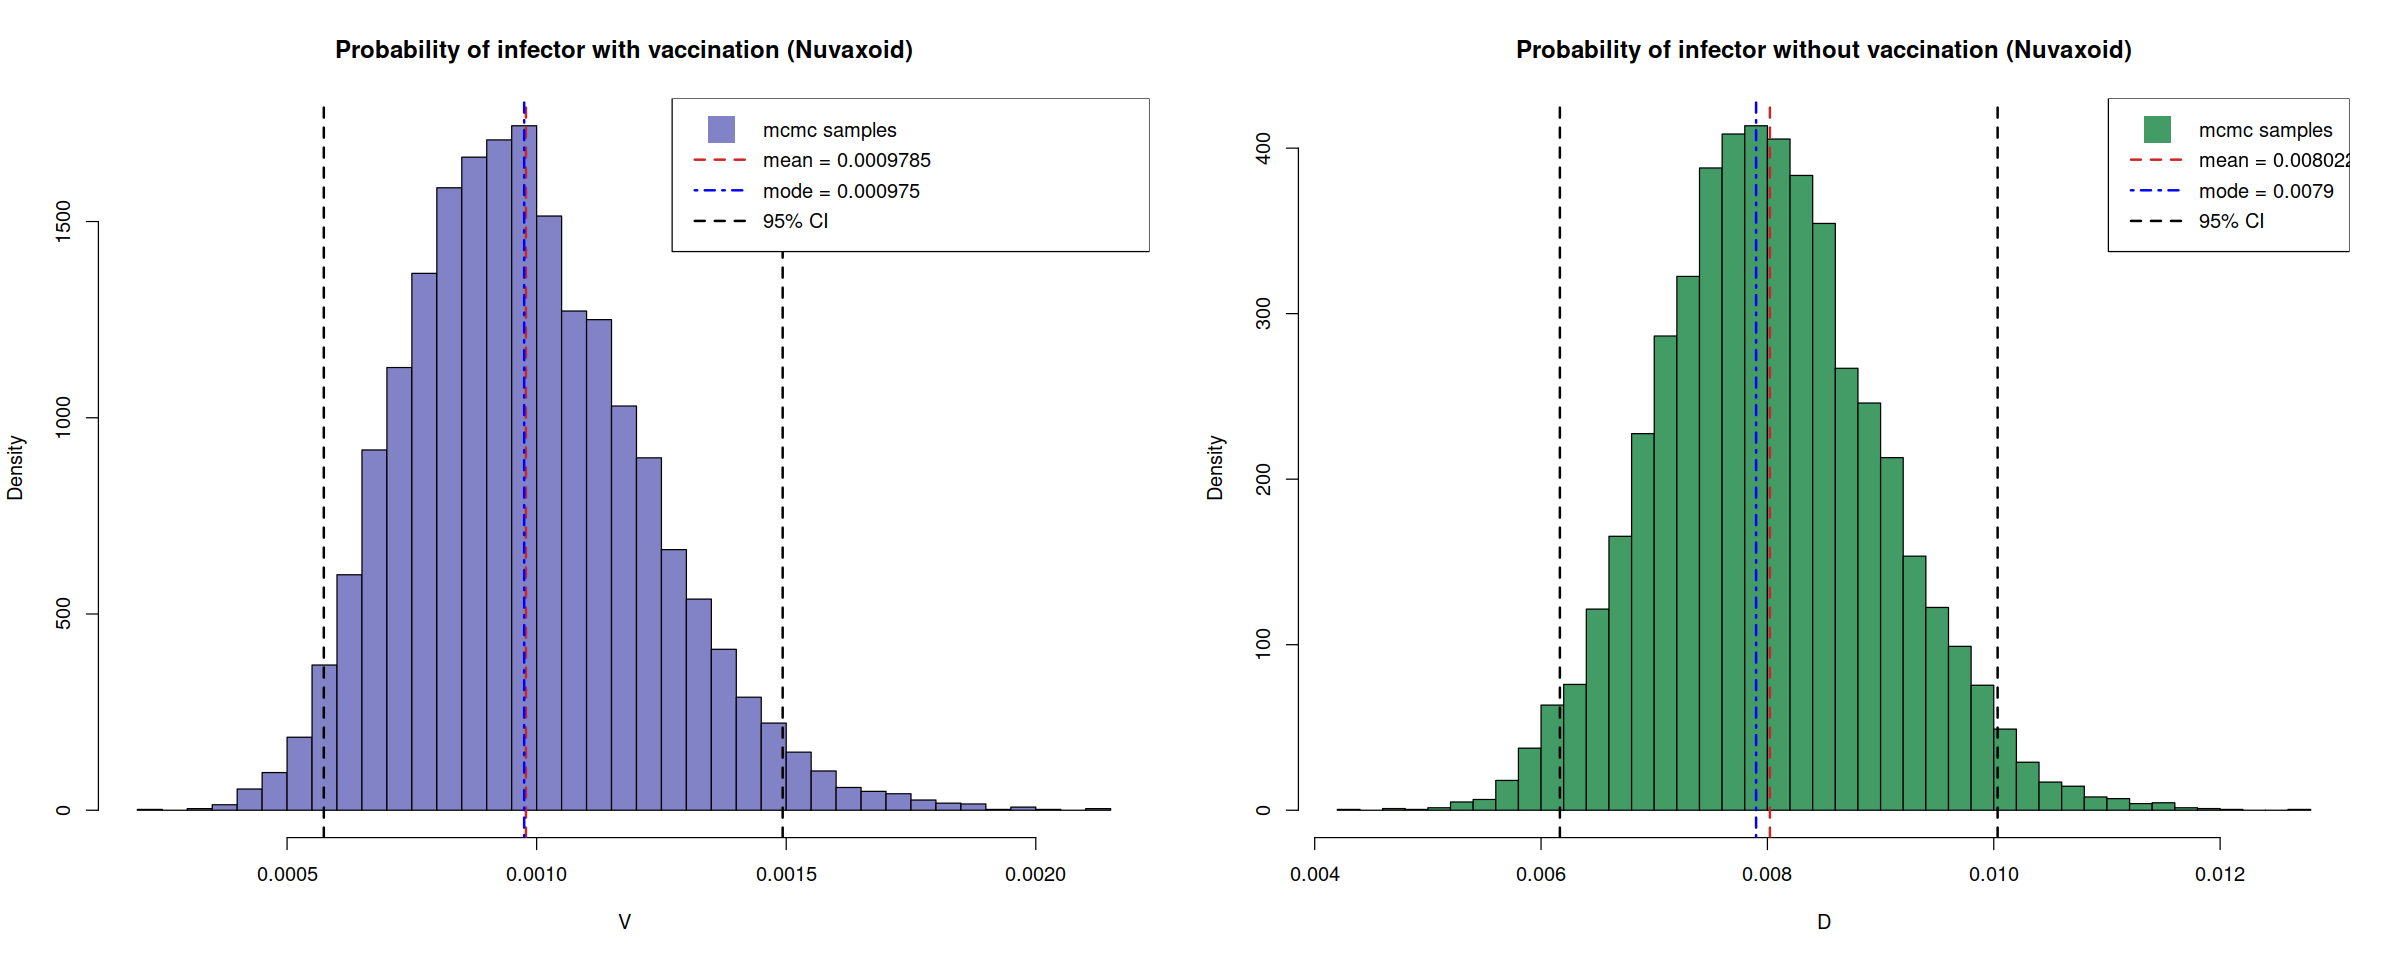

mean      median    mode   CI95_low  CI95_high
1 0.8762048 0.8796719 0.8875 0.8008247 0.9318164

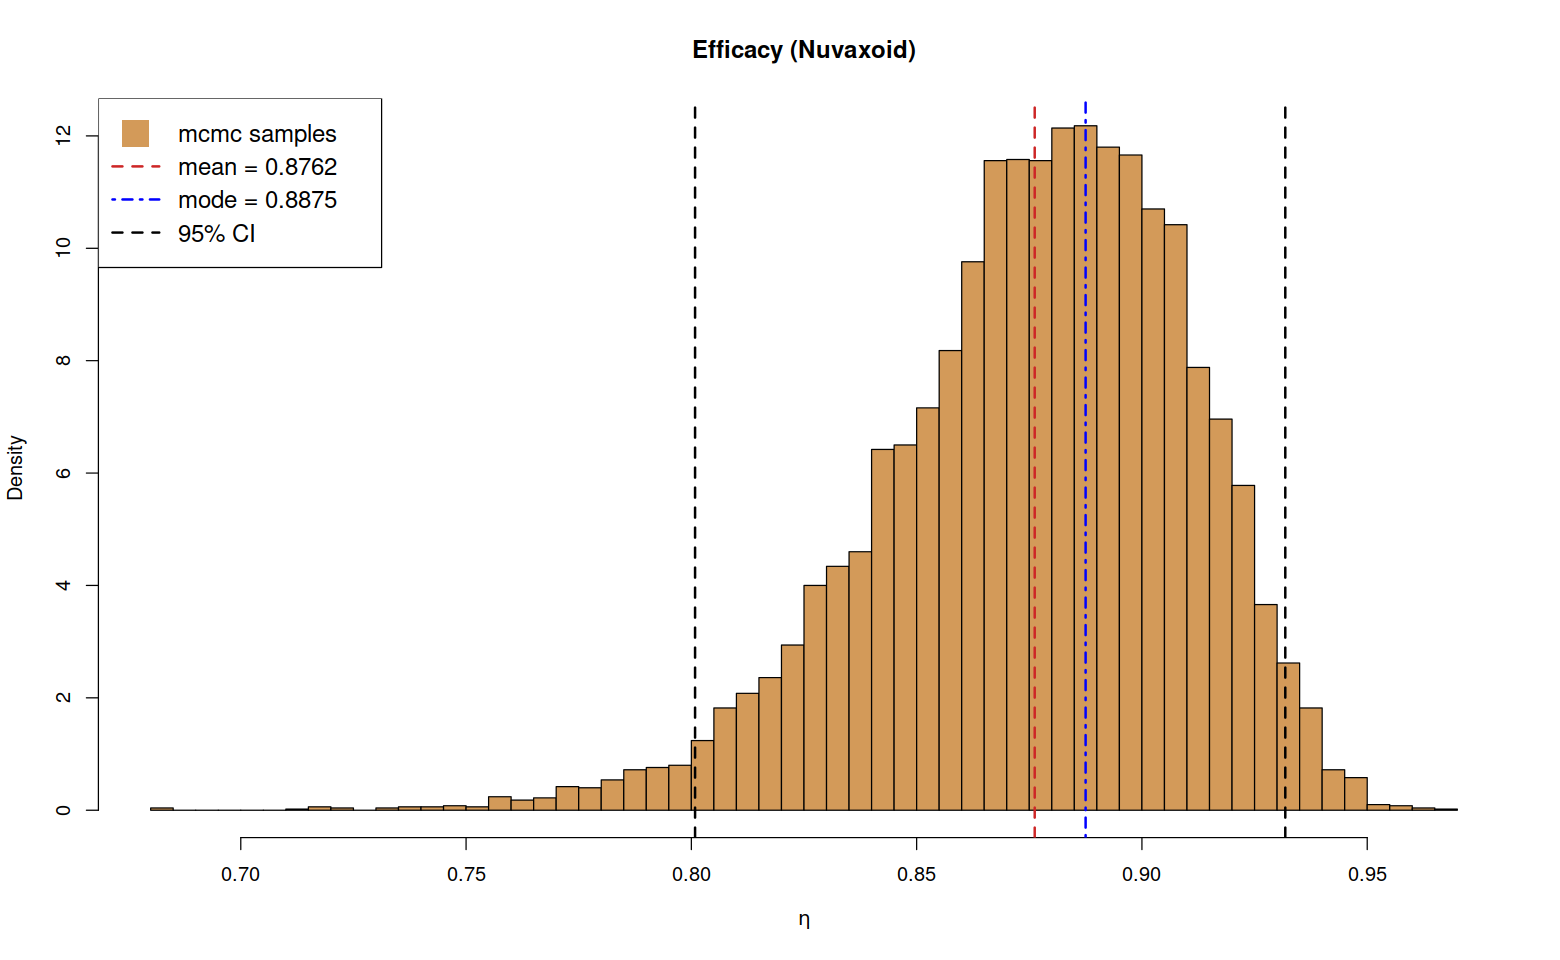

In [21]:
chain_tbl = as_tibble(as.mcmc(chain_vax))
chain_tbl = chain_tbl %>% 
        rename(p_vax = 1) %>% 
        mutate(p_placebo = as.double(as.mcmc(chain_placebo))) %>% 
        mutate(p_eff = (p_placebo - p_vax) / p_placebo)

# p histogram = p posterior
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow = c(1,2))

h = hist(chain_tbl$p_vax, breaks = 'Scott', freq = FALSE, col = '#8282c7', xlab = 'V',
        main = 'Probability of infector with vaccination (Nuvaxoid)')
abline(v = results_vax$statistics['Mean'], col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(results_vax$quantiles['2.5%'], results_vax$quantiles['97.5%']), col = 'black', lty = 2, lwd = 2)
legend('topright', legend = c('mcmc samples', paste('mean =', format(results_vax$statistics['Mean'], digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#8282c7', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), text.width = 0.0007, seg.len = 0.7, x.intersp = 0.2, pt.cex = 3)

h = hist(chain_tbl$p_placebo, breaks = 'Scott', freq = FALSE, col = '#439c65', xlab = 'D',
        main = 'Probability of infector without vaccination (Nuvaxoid)')
abline(v = results_placebo$statistics['Mean'], col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(results_placebo$quantiles['2.5%'], results_placebo$quantiles['97.5%']), col = 'black', lty = 2, lwd = 2)
legend('topright', legend = c('mcmc samples', paste('mean =', format(results_placebo$statistics['Mean'], digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#439c65', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), text.width = 0.001, seg.len = 0.7, x.intersp = 0.2, pt.cex = 3)

options(repr.plot.width=13, repr.plot.height=8)
par(mfrow = c(1,1))
h = hist(chain_tbl$p_eff, breaks = 'Freedman-Diaconis', freq = FALSE, col = '#d39a59', xlab = expression(eta),
        main = 'Efficacy (Nuvaxoid)')
abline(v = mean(chain_tbl$p_eff), col = 'firebrick3', lty = 2, lwd = 2)

mode = h$mids[h$counts == max(h$counts)]

abline(v = mode, col = 'blue', lty = 4, lwd = 2)
abline(v = c(unname(quantile(chain_tbl$p_eff, 0.025)), unname(quantile(chain_tbl$p_eff, 0.975))), col = 'black', lty = 2, lwd = 2)
legend('topleft', legend = c('mcmc samples', paste('mean =', format(mean(chain_tbl$p_eff), digits = 4)), paste('mode =', format(mode, digits = 4)), '95% CI'), 
        col = c('#d39a59', 'firebrick3', 'blue', 'black'),
        lty = c(NA, 2, 4, 2), lwd = c(NA, 2, 2, 2), pch = c(15, NA, NA, NA), cex = 1.2, seg.len = 1, text.width = 0.04, x.intersp = 0.4, y.intersp = 0.9, pt.cex = 3)

efficacy_tbl = chain_tbl %>% 
        select(p_eff) %>% 
        summarise(mean = mean(p_eff), 
                median = median(p_eff), 
                mode = mode, 
                CI95_low = unname(quantile(p_eff, 0.025)), 
                CI95_high = unname(quantile(p_eff, 0.975)))
efficacy_tbl

# Exercise 3

- according to the official COVID-19 vaccination data, 70% of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination dataset is available.
- the European Centre for Disease Prevention and Control published a downloadable file containing information on COVID-19 vaccination in the EU/EEA
- Analyze the data and produce the following plots
    - number of vaccinated people (cumulative, daily and week average)
    - number of confirmed deaths by COVID-19, both cumulative and weekly average

Here we load the dataset and inspect it.

In [22]:
owid_dataset = read.csv('owid-covid-data.csv')

In [23]:
owid_dataset = as_tibble(owid_dataset)
head(owid_dataset)

iso_code continent location    date       total_cases new_cases
1 AFG      Asia      Afghanistan 2020-01-03 NA          0        
2 AFG      Asia      Afghanistan 2020-01-04 NA          0        
3 AFG      Asia      Afghanistan 2020-01-05 NA          0        
4 AFG      Asia      Afghanistan 2020-01-06 NA          0        
5 AFG      Asia      Afghanistan 2020-01-07 NA          0        
6 AFG      Asia      Afghanistan 2020-01-08 NA          0        
  new_cases_smoothed total_deaths new_deaths new_deaths_smoothed ⋯ male_smokers
1 NA                 NA           0          NA                  ⋯ NA          
2 NA                 NA           0          NA                  ⋯ NA          
3 NA                 NA           0          NA                  ⋯ NA          
4 NA                 NA           0          NA                  ⋯ NA          
5 NA                 NA           0          NA                  ⋯ NA          
6  0                 NA           0           0                  ⋯ NA          
  handwashing_facilities hospital_beds_per_thousand life_expectancy
1 37.746                 0.5                        64.83          
2 37.746                 0.5                        64.83          
3 37.746                 0.5                        64.83          
4 37.746                 0.5                        64.83          
5 37.746                 0.5                        64.83          
6 37.746                 0.5                        64.83          
  human_development_index population excess_mortality_cumulative_absolute
1 0.511                   41128772   NA                                  
2 0.511                   41128772   NA                                  
3 0.511                   41128772   NA                                  
4 0.511                   41128772   NA                                  
5 0.511                   41128772   NA                                  
6 0.511                   41128772   NA                                  
  excess_mortality_cumulative excess_mortality
1 NA                          NA              
2 NA                          NA              
3 NA                          NA              
4 NA                          NA              
5 NA                          NA              
6 NA                          NA              
  excess_mortality_cumulative_per_million
1 NA                                     
2 NA                                     
3 NA                                     
4 NA                                     
5 NA                                     
6 NA

## Global data

Here we create the plot of the number of daily vaccinatios (i.e. the number of shots performed every day)

date       daily_new_doses
1 2020-12-02 0              
2 2020-12-03 3              
3 2020-12-04 3              
4 2020-12-05 3              
5 2020-12-06 3              
6 2020-12-07 3

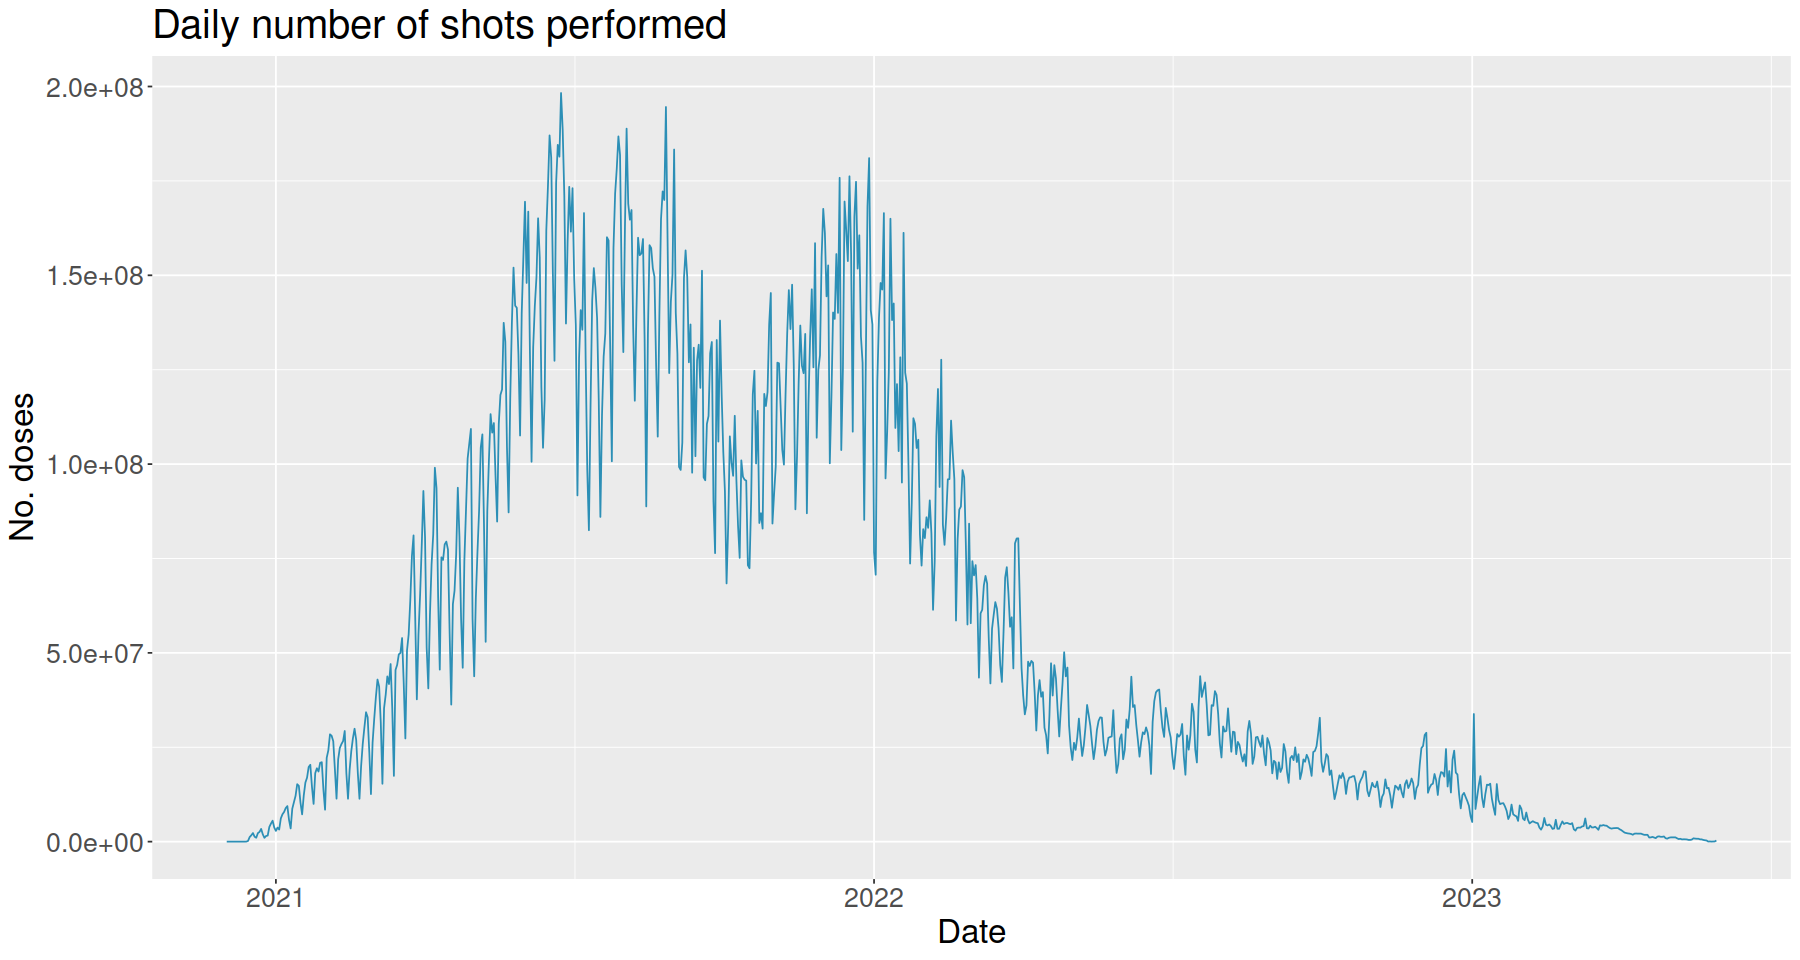

In [24]:
# daily plot
dnd_tbl = owid_dataset %>%
        select(date, new_vaccinations) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>% 
        group_by(date) %>% 
        summarise(daily_new_doses = sum(new_vaccinations))
head(dnd_tbl)

options(repr.plot.width=15, repr.plot.height=8)
p1 = ggplot(data = dnd_tbl) + geom_line(aes(x = date, y = daily_new_doses), colour = '#2c8fb6') +
        labs(x = 'Date', y = 'No. doses', title = 'Daily number of shots performed') +
        theme(text = element_text(size = 20))
p1

Here we create the plot of the weekly average number of shots performed.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year week_num wa_new_doses date      
1 2020 48       1.714286e+00 2020-11-30
2 2020 49       5.285714e+00 2020-12-07
3 2020 50       1.106846e+06 2020-12-14
4 2020 51       2.038895e+06 2020-12-21
5 2020 52       2.568272e+06 2020-12-28
6 2021  0       1.396872e+06 2021-01-04

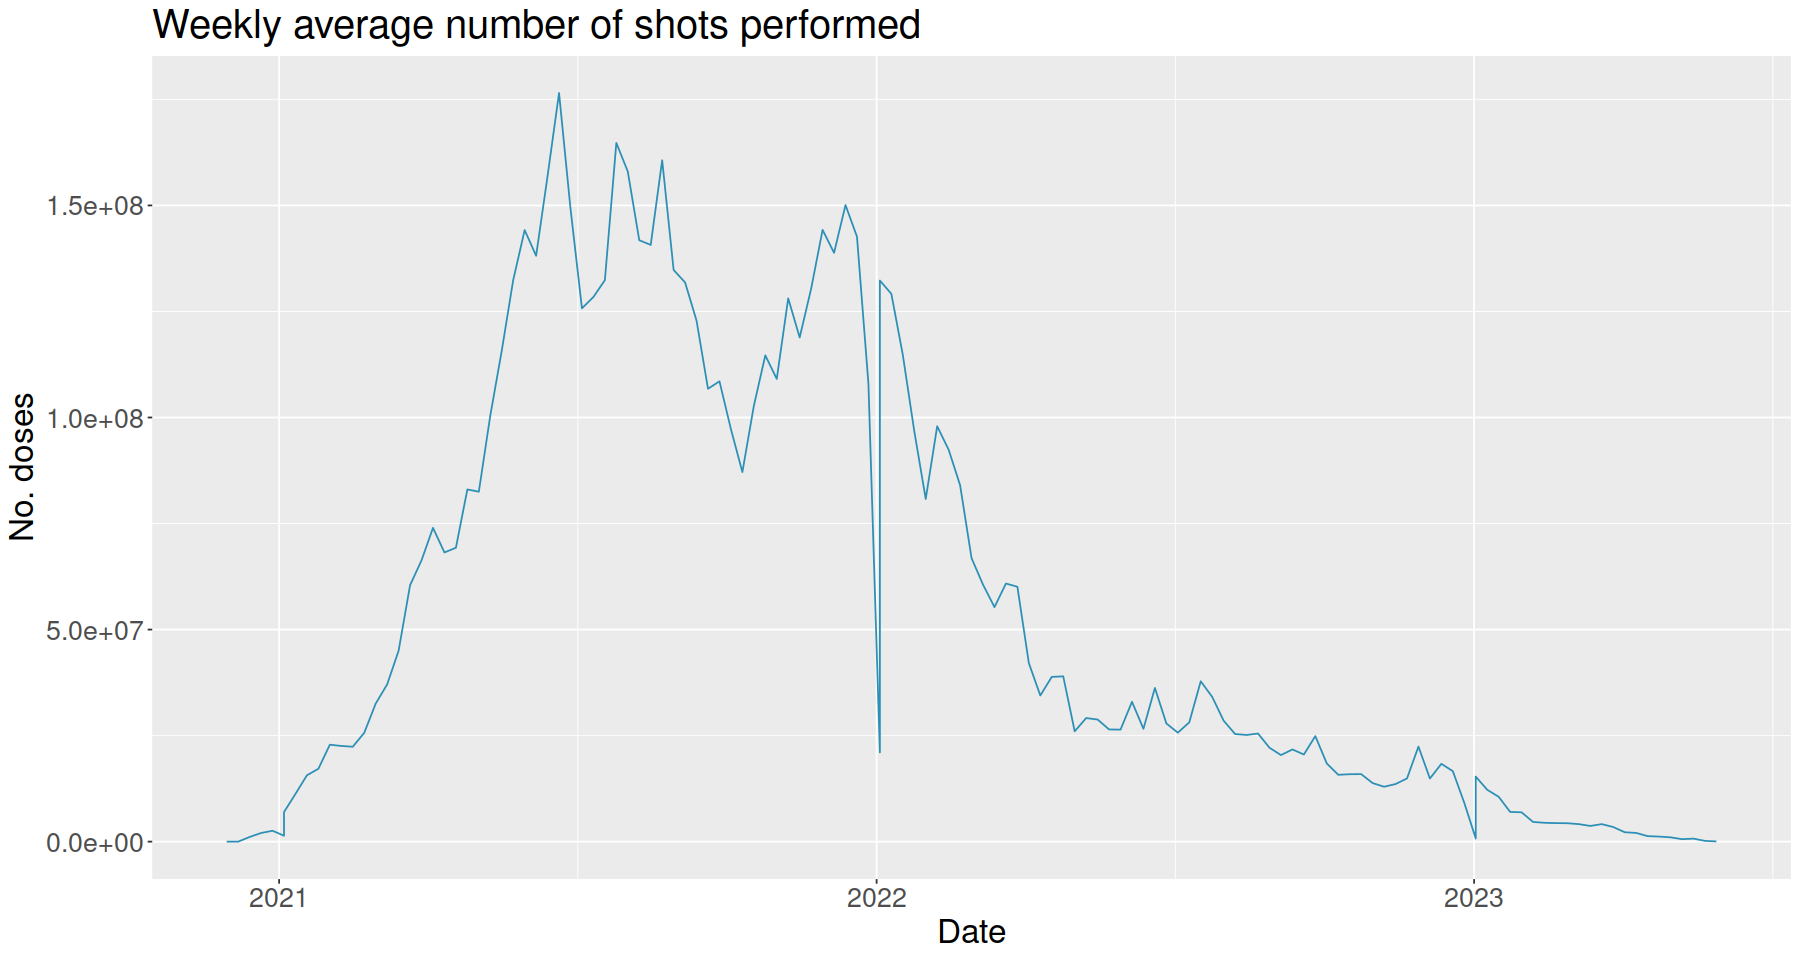

In [25]:
# weekly average
wand_tbl = owid_dataset %>%
        select(date, new_vaccinations) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>% 
        mutate(week_num = strftime(date, format = '%W')) %>%
        mutate(week_num = as.integer(week_num)) %>%  
        mutate(year = strftime(date, format = '%Y')) %>%
        mutate(year = as.integer(year)) %>% 
        group_by(year, week_num) %>% 
        summarise(wa_new_doses = sum(new_vaccinations) / 7) %>% 
        ungroup() %>% 
        mutate(date = as_date(paste(year, week_num, 1, sep = '-'), format = '%Y-%U-%u'))
head(wand_tbl)

p2 = ggplot(data = wand_tbl) + geom_line(aes(x = date, y = wa_new_doses), colour = '#2c8fb6') +
        labs(x = 'Date', y = 'No. doses', title = 'Weekly average number of shots performed') +
        theme(text = element_text(size = 20))
p2

Here we create the cumulative plot of shots performed.

date       daily_new_doses cum_new_doses
1 2020-12-02 0                0           
2 2020-12-03 3                3           
3 2020-12-04 3                6           
4 2020-12-05 3                9           
5 2020-12-06 3               12           
6 2020-12-07 3               15

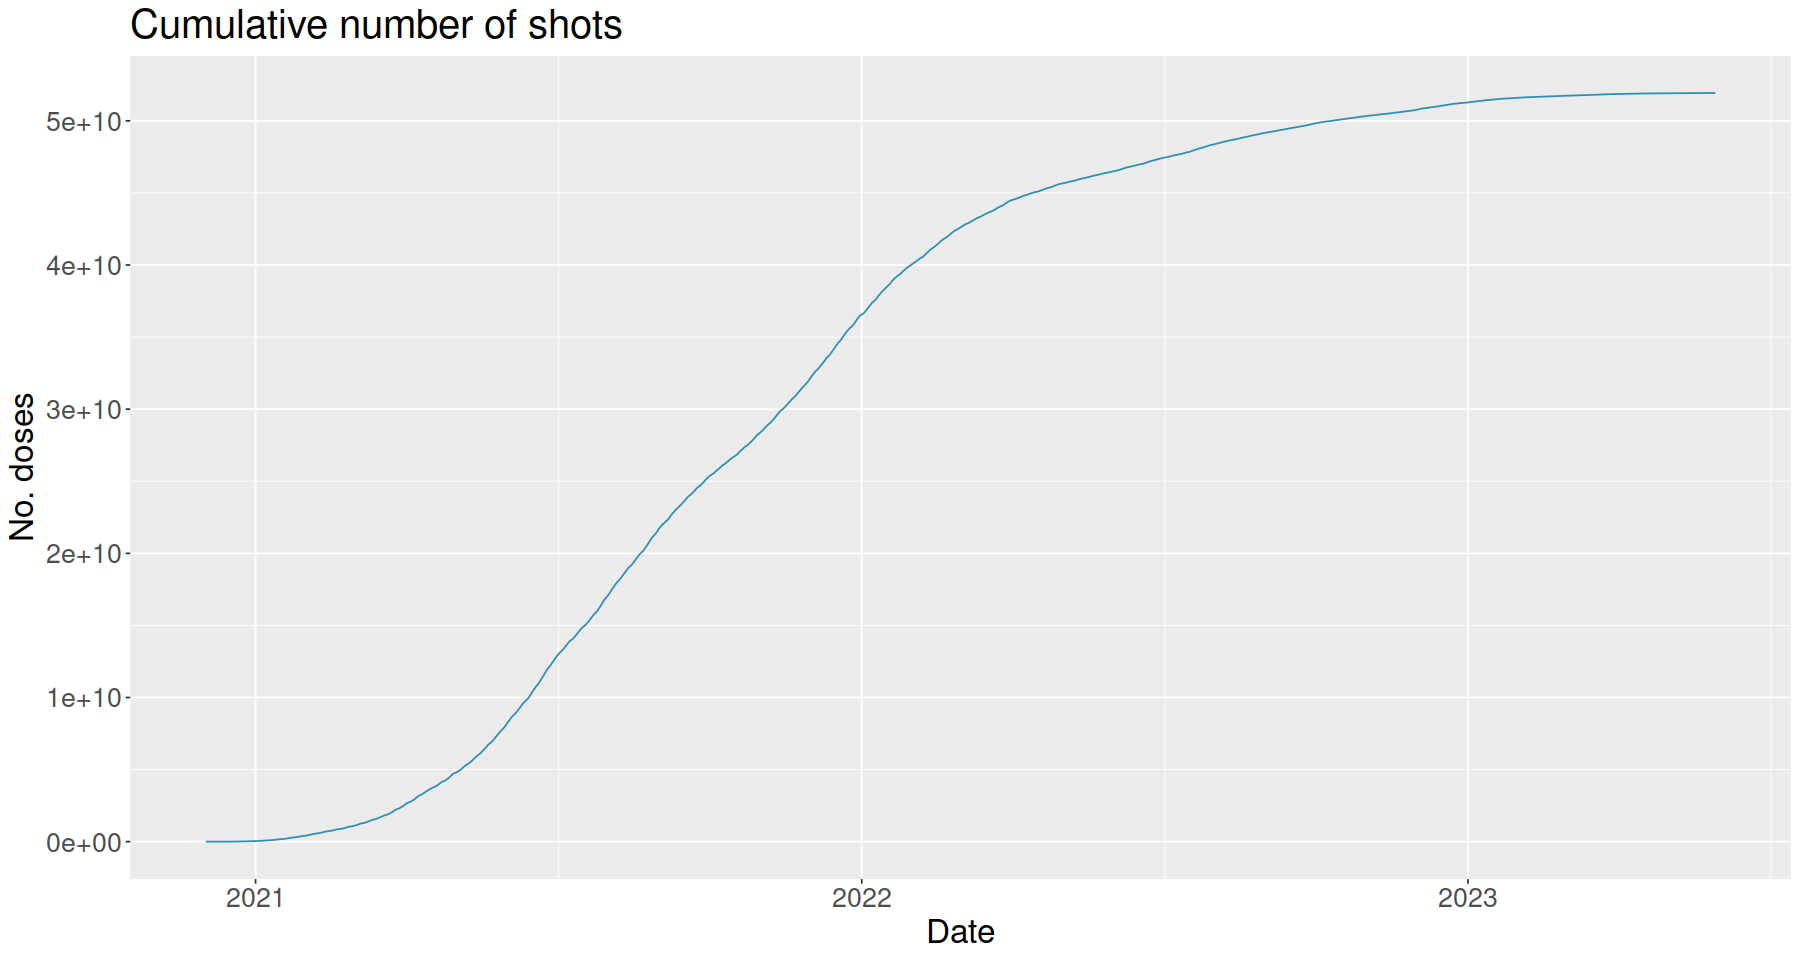

In [26]:
# cumulative, method 1
cumnd_tbl = owid_dataset %>%
        select(date, new_vaccinations) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>%
        group_by(date) %>% 
        summarize(daily_new_doses = sum(new_vaccinations)) %>% 
        mutate(cum_new_doses = cumsum(daily_new_doses))
head(cumnd_tbl)

p3 = ggplot(data = cumnd_tbl) + geom_line(aes(x = date, y = cum_new_doses), colour = '#2c8fb6') +
        labs(x = 'Date', y = 'No. doses', title = 'Cumulative number of shots') +
        theme(text = element_text(size = 20))
p3

Here we create the plot of the weekly average number of deaths.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year week_num wa_new_deaths date      
1 2020 0          0.0000000   2020-01-06
2 2020 1          0.5714286   2020-01-06
3 2020 2          1.1428571   2020-01-13
4 2020 3         30.2857143   2020-01-20
5 2020 4        175.4285714   2020-01-27
6 2020 5        311.4285714   2020-02-03

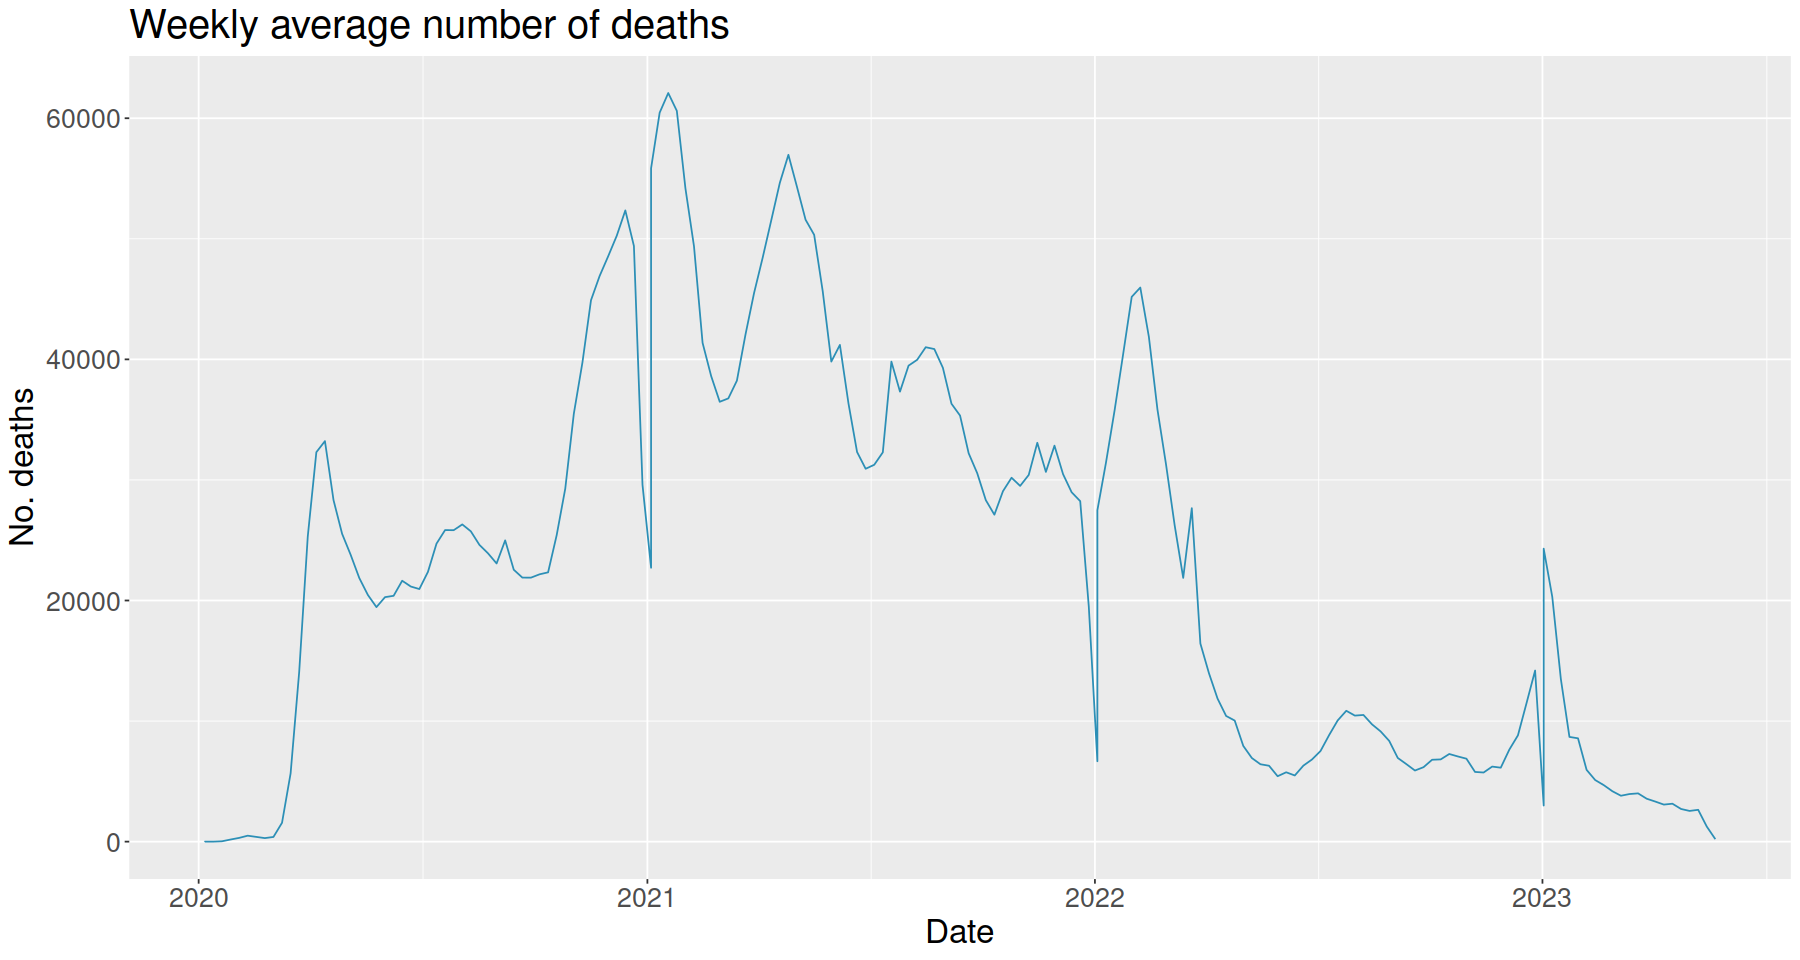

In [27]:
# deaths weekly average
wandeaths_tbl = owid_dataset %>%
        select(date, new_deaths) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>% 
        mutate(week_num = strftime(date, format = '%W')) %>%
        mutate(week_num = as.integer(week_num)) %>%  
        mutate(year = strftime(date, format = '%Y')) %>%
        mutate(year = as.integer(year)) %>% 
        group_by(year, week_num) %>% 
        summarise(wa_new_deaths = sum(new_deaths) / 7) %>% 
        ungroup() %>% 
        mutate(date = as_date(paste(year, week_num, 1, sep = '-'), format = '%Y-%U-%u'))
head(wandeaths_tbl)

p4 = ggplot(data = wandeaths_tbl) + geom_line(aes(x = date, y = wa_new_deaths), colour = '#2c8fb6') + 
        labs(x = 'Date', y = 'No. deaths', title = 'Weekly average number of deaths') +
        theme(text = element_text(size = 20))
p4

Here we create the cumulative plot of the deaths.

date       daily_new_deaths cum_new_deaths
1 2020-01-03 0                0             
2 2020-01-04 0                0             
3 2020-01-05 0                0             
4 2020-01-06 0                0             
5 2020-01-07 0                0             
6 2020-01-08 0                0

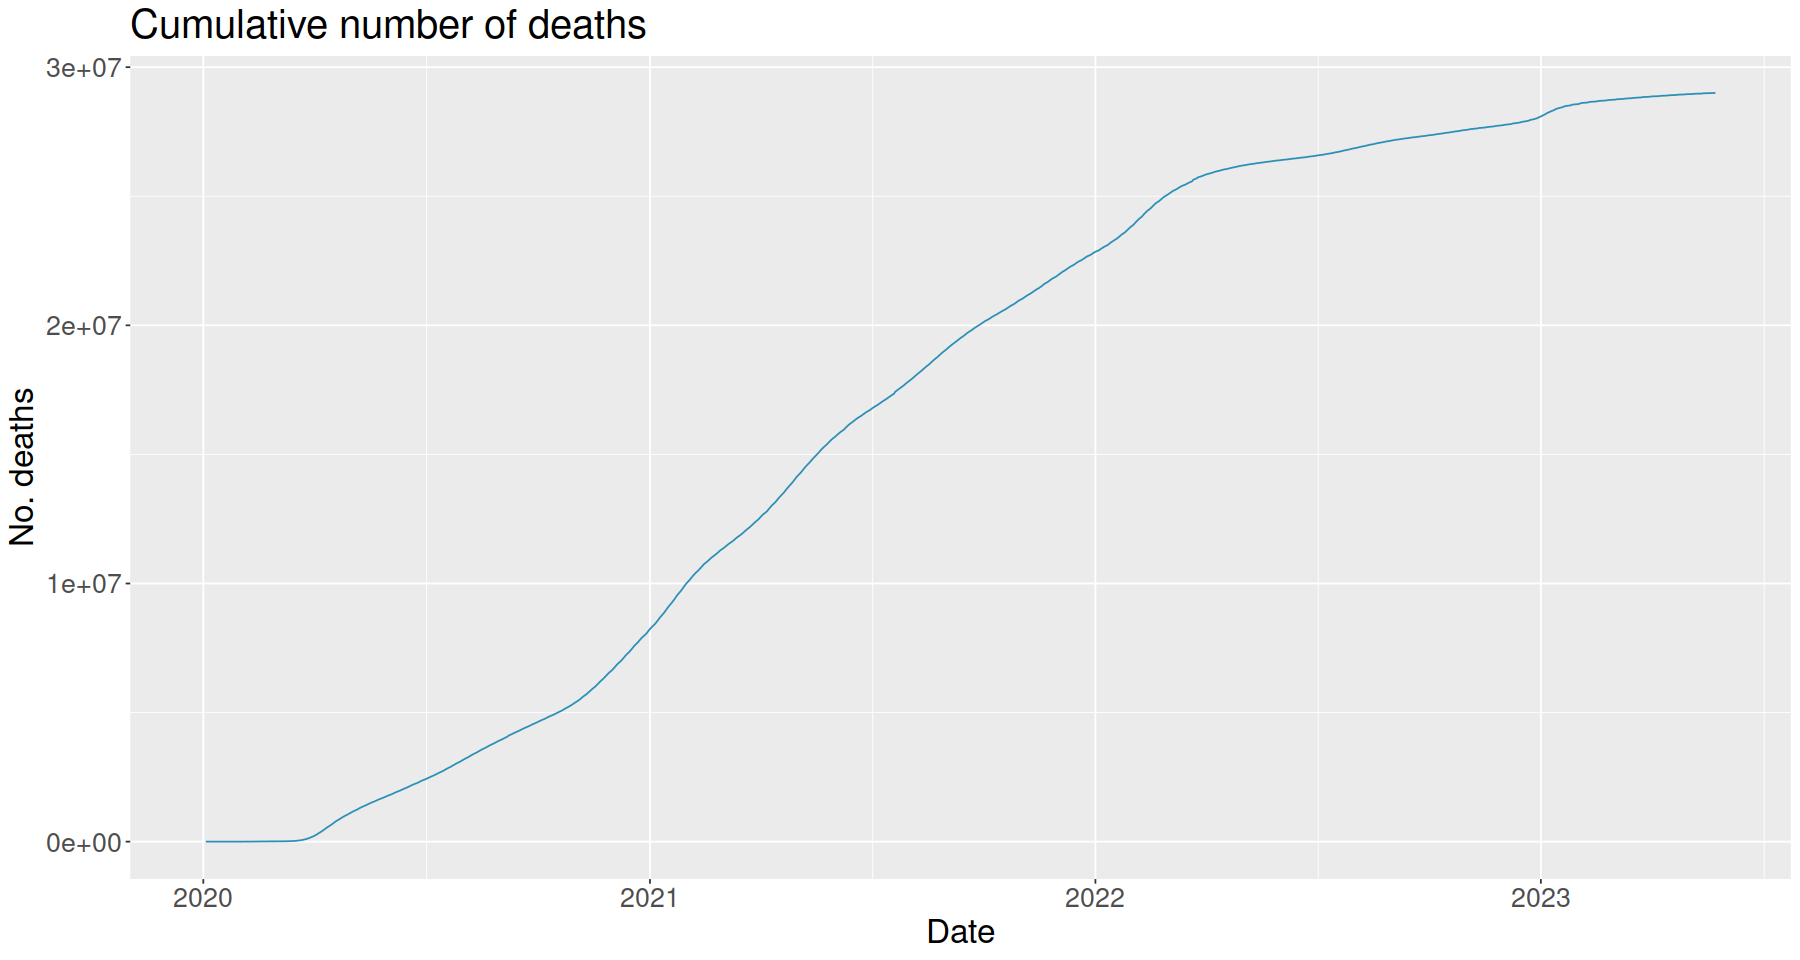

In [28]:
# deaths cumulative, method 1
cumndeaths_tbl = owid_dataset %>%
        select(date, new_deaths) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>%
        group_by(date) %>% 
        summarize(daily_new_deaths = sum(new_deaths)) %>% 
        mutate(cum_new_deaths = cumsum(daily_new_deaths))
head(cumndeaths_tbl)

p5 = ggplot(data = cumndeaths_tbl) + geom_line(aes(x = date, y = cum_new_deaths), colour = '#2c8fb6') +
        labs(x = 'Date', y = 'No. deaths', title = 'Cumulative number of deaths') +
        theme(text = element_text(size = 20))
p5

## European data

New vaccine doses (daily, weekly average, cumulative)

date       daily_new_doses
1 2020-12-09  1             
2 2020-12-10  1             
3 2020-12-11  4             
4 2020-12-12  1             
5 2020-12-16  6             
6 2020-12-17 10

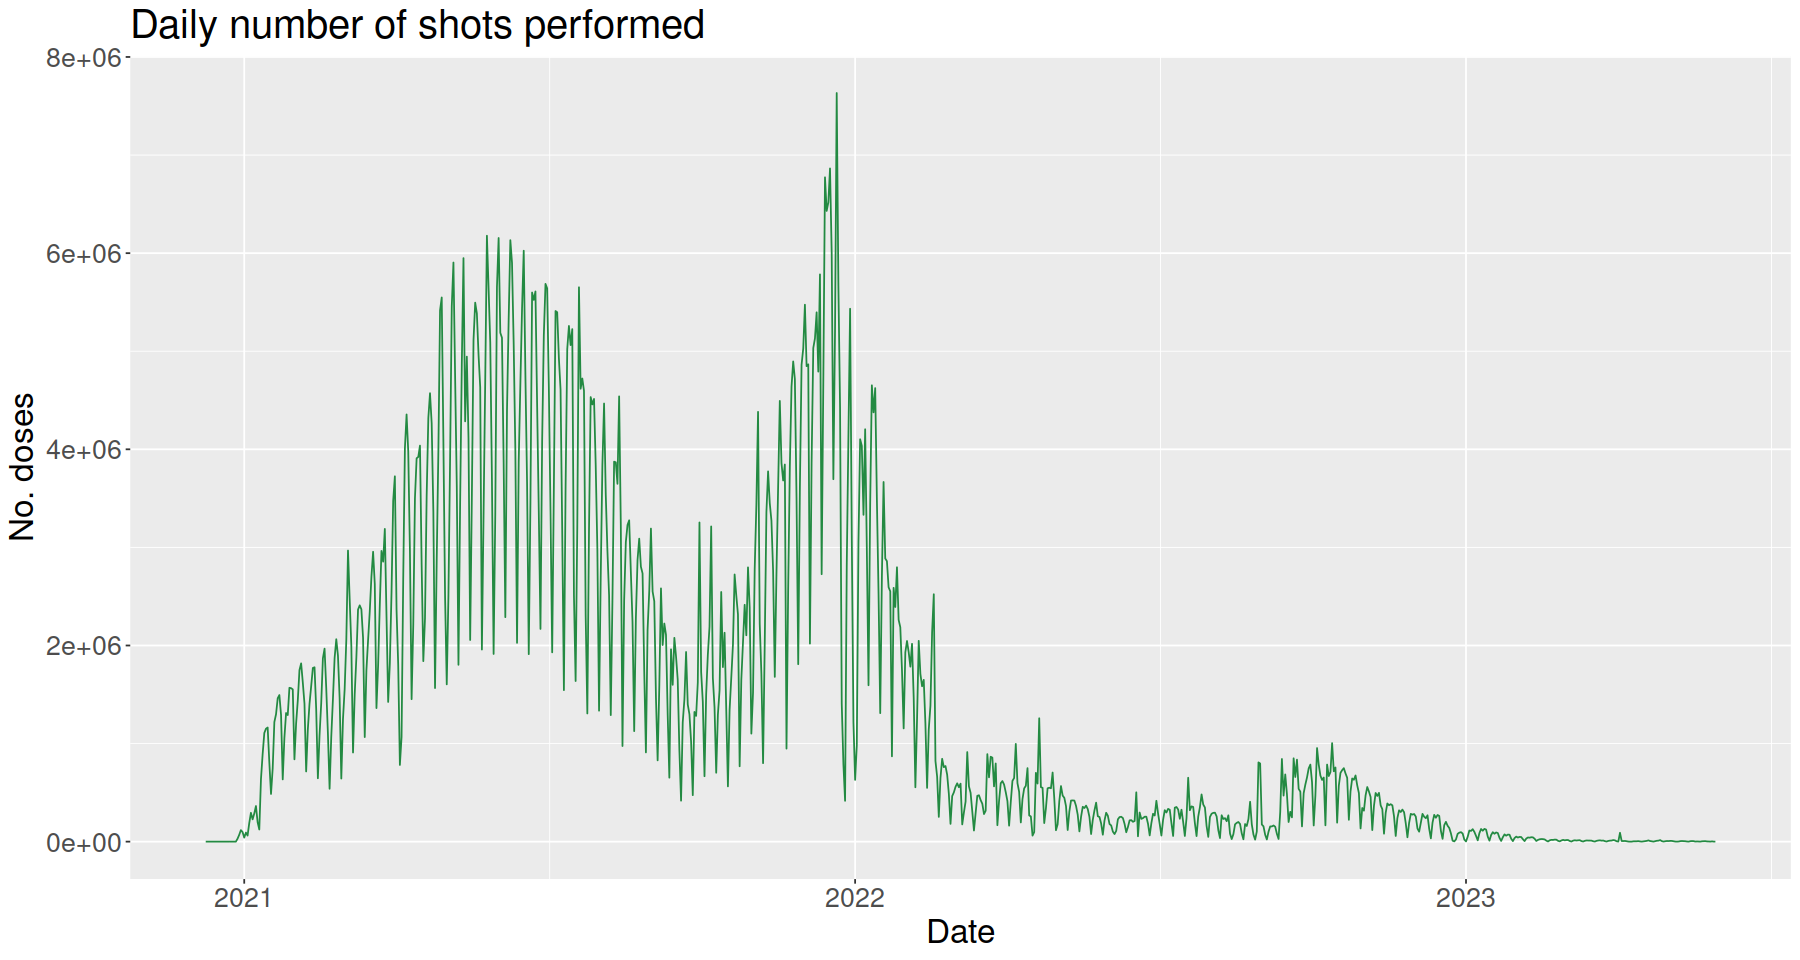

In [29]:
# daily plot
dnd_europe_tbl = owid_dataset %>%
        filter(continent == 'Europe') %>%
        select(date, new_vaccinations) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>% 
        group_by(date) %>% 
        summarise(daily_new_doses = sum(new_vaccinations))
head(dnd_europe_tbl)

p6 = ggplot(data = dnd_europe_tbl) + geom_line(aes(x = date, y = daily_new_doses), colour = '#238a42') +
        labs(x = 'Date', y = 'No. doses', title = 'Daily number of shots performed') +
        theme(text = element_text(size = 20))
p6

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year week_num wa_new_doses date      
1 2020 49       1.000000e+00 2020-12-07
2 2020 50       6.714286e+00 2020-12-14
3 2020 51       1.754286e+02 2020-12-21
4 2020 52       4.500143e+04 2020-12-28
5 2021  0       2.791286e+04 2021-01-04
6 2021  1       2.403244e+05 2021-01-04

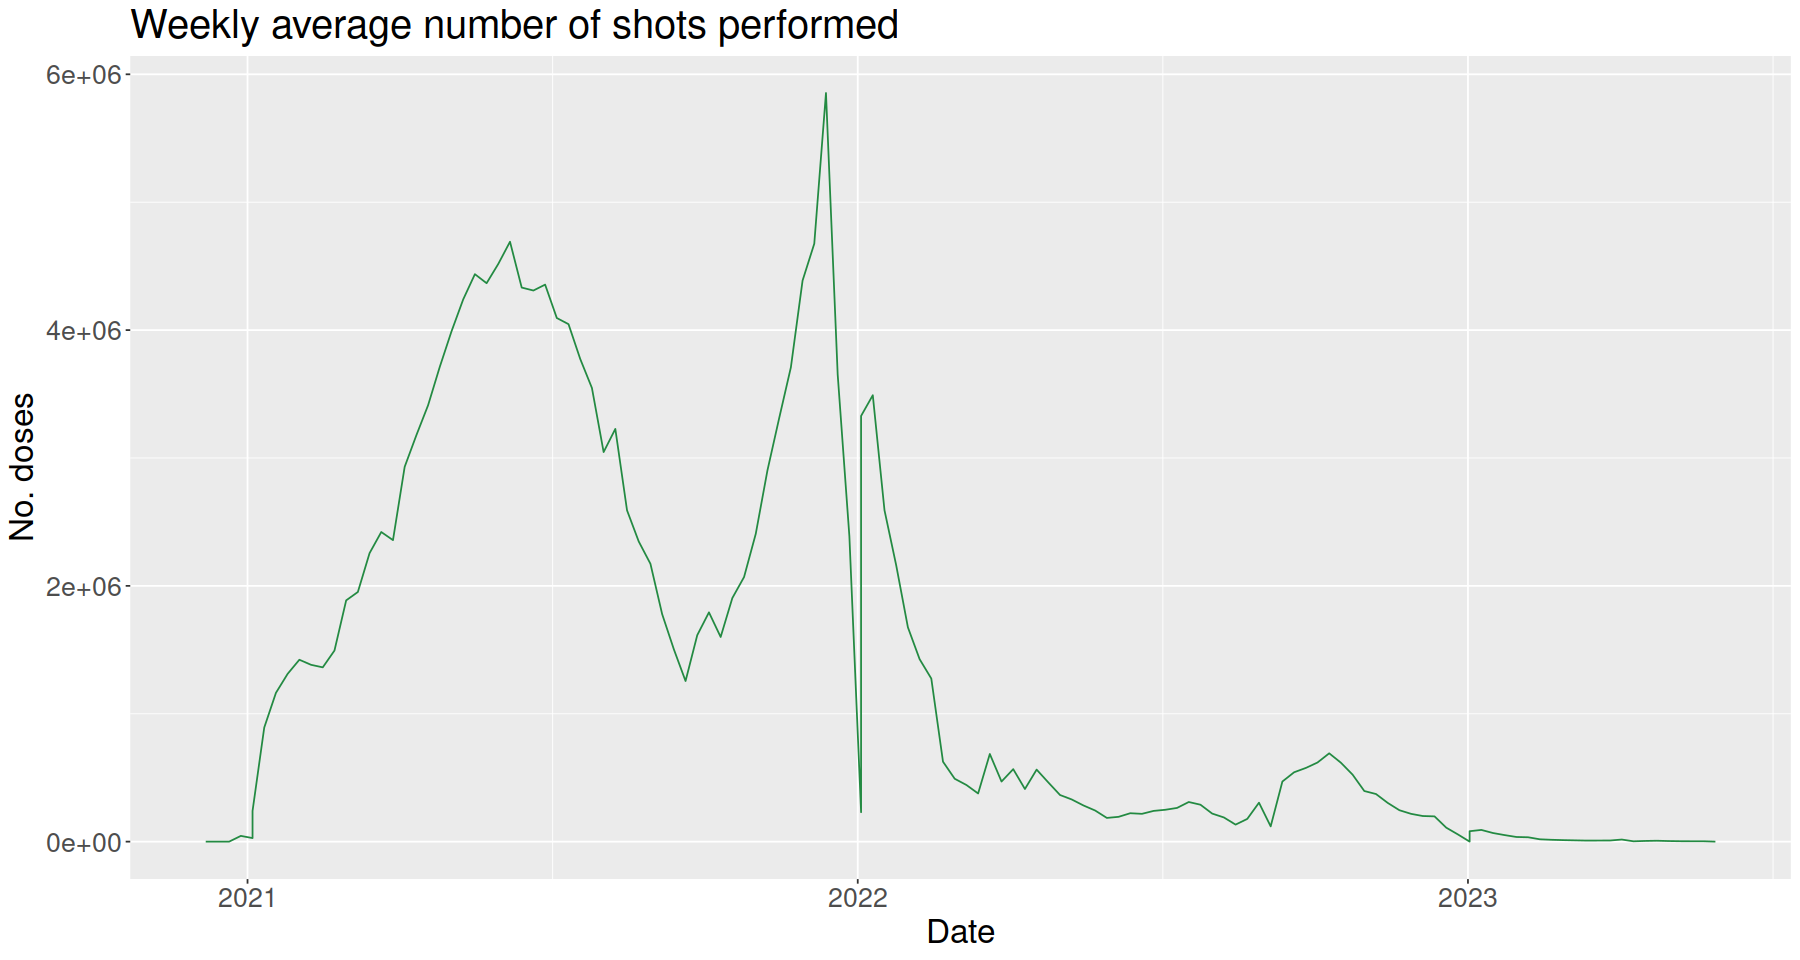

In [30]:
# weekly average
wand_europe_tbl = owid_dataset %>%
        filter(continent == 'Europe') %>% 
        select(date, new_vaccinations) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>% 
        mutate(week_num = strftime(date, format = '%W')) %>%
        mutate(week_num = as.integer(week_num)) %>%  
        mutate(year = strftime(date, format = '%Y')) %>%
        mutate(year = as.integer(year)) %>% 
        group_by(year, week_num) %>% 
        summarise(wa_new_doses = sum(new_vaccinations) / 7) %>% 
        ungroup() %>% 
        mutate(date = as_date(paste(year, week_num, 1, sep = '-'), format = '%Y-%U-%u'))
head(wand_europe_tbl)

p7 = ggplot(data = wand_europe_tbl) + geom_line(aes(x = date, y = wa_new_doses), colour = '#238a42') +
        labs(x = 'Date', y = 'No. doses', title = 'Weekly average number of shots performed') +
        theme(text = element_text(size = 20))
p7

date       daily_new_doses cum_new_doses
1 2020-12-09  1               1           
2 2020-12-10  1               2           
3 2020-12-11  4               6           
4 2020-12-12  1               7           
5 2020-12-16  6              13           
6 2020-12-17 10              23

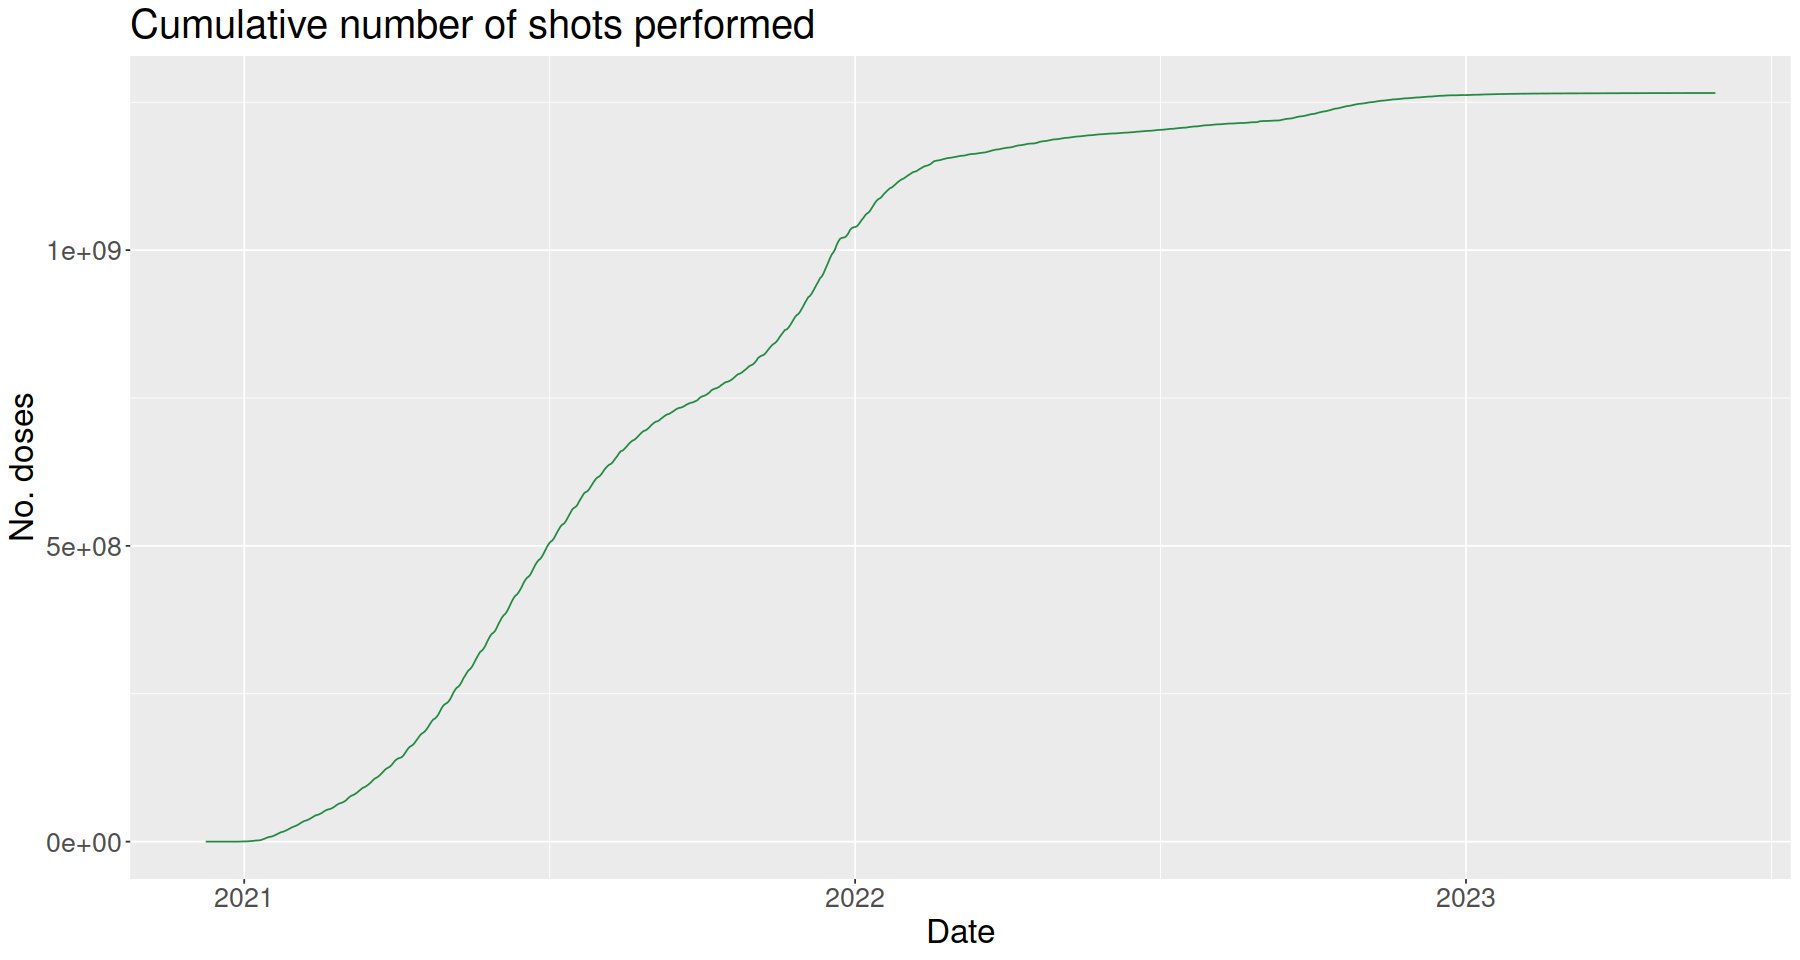

In [31]:
# cumulative, method 1
cumnd_europe_tbl = owid_dataset %>%
        filter(continent == 'Europe') %>% 
        select(date, new_vaccinations) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>%
        group_by(date) %>% 
        summarize(daily_new_doses = sum(new_vaccinations)) %>% 
        mutate(cum_new_doses = cumsum(daily_new_doses))
head(cumnd_europe_tbl)

p8 = ggplot(data = cumnd_europe_tbl) + geom_line(aes(x = date, y = cum_new_doses), colour = '#238a42') +
        labs(x = 'Date', y = 'No. doses', title = 'Cumulative number of shots performed') +
        theme(text = element_text(size = 20))
p8

Number of confirmed deaths (weekly average, cumulative)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year week_num wa_new_deaths date      
1 2020 0        0.0000000     2020-01-06
2 2020 1        0.0000000     2020-01-06
3 2020 2        0.0000000     2020-01-13
4 2020 3        0.0000000     2020-01-20
5 2020 4        0.1428571     2020-01-27
6 2020 5        0.1428571     2020-02-03

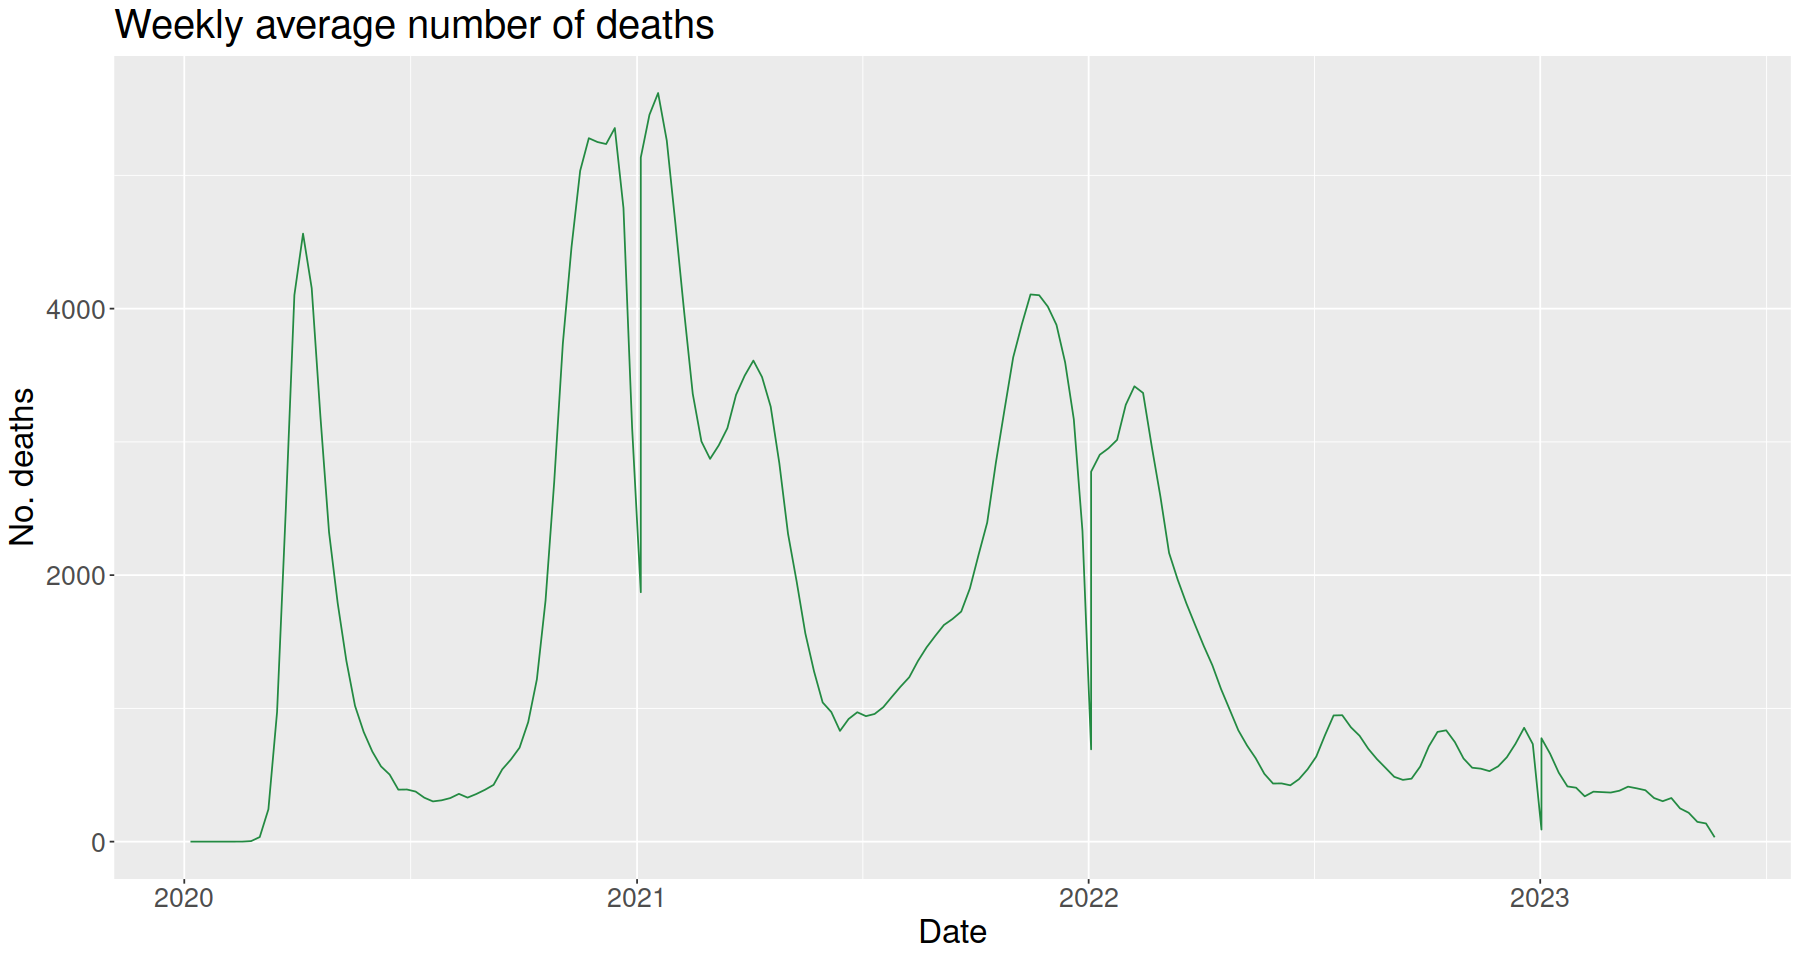

In [32]:
# deaths weekly average
wandeaths_europe_tbl = owid_dataset %>%
        filter(continent == 'Europe') %>% 
        select(date, new_deaths) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>% 
        mutate(week_num = strftime(date, format = '%W')) %>%
        mutate(week_num = as.integer(week_num)) %>%  
        mutate(year = strftime(date, format = '%Y')) %>%
        mutate(year = as.integer(year)) %>% 
        group_by(year, week_num) %>% 
        summarise(wa_new_deaths = sum(new_deaths) / 7) %>% 
        ungroup() %>% 
        mutate(date = as_date(paste(year, week_num, 1, sep = '-'), format = '%Y-%U-%u'))
head(wandeaths_europe_tbl)

p9 = ggplot(data = wandeaths_europe_tbl) + geom_line(aes(x = date, y = wa_new_deaths), colour = '#238a42') +
        labs(x = 'Date', y = 'No. deaths', title = 'Weekly average number of deaths') +
        theme(text = element_text(size = 20))
p9

date       daily_new_deaths cum_new_deaths
1 2020-01-03 0                0             
2 2020-01-04 0                0             
3 2020-01-05 0                0             
4 2020-01-06 0                0             
5 2020-01-07 0                0             
6 2020-01-08 0                0

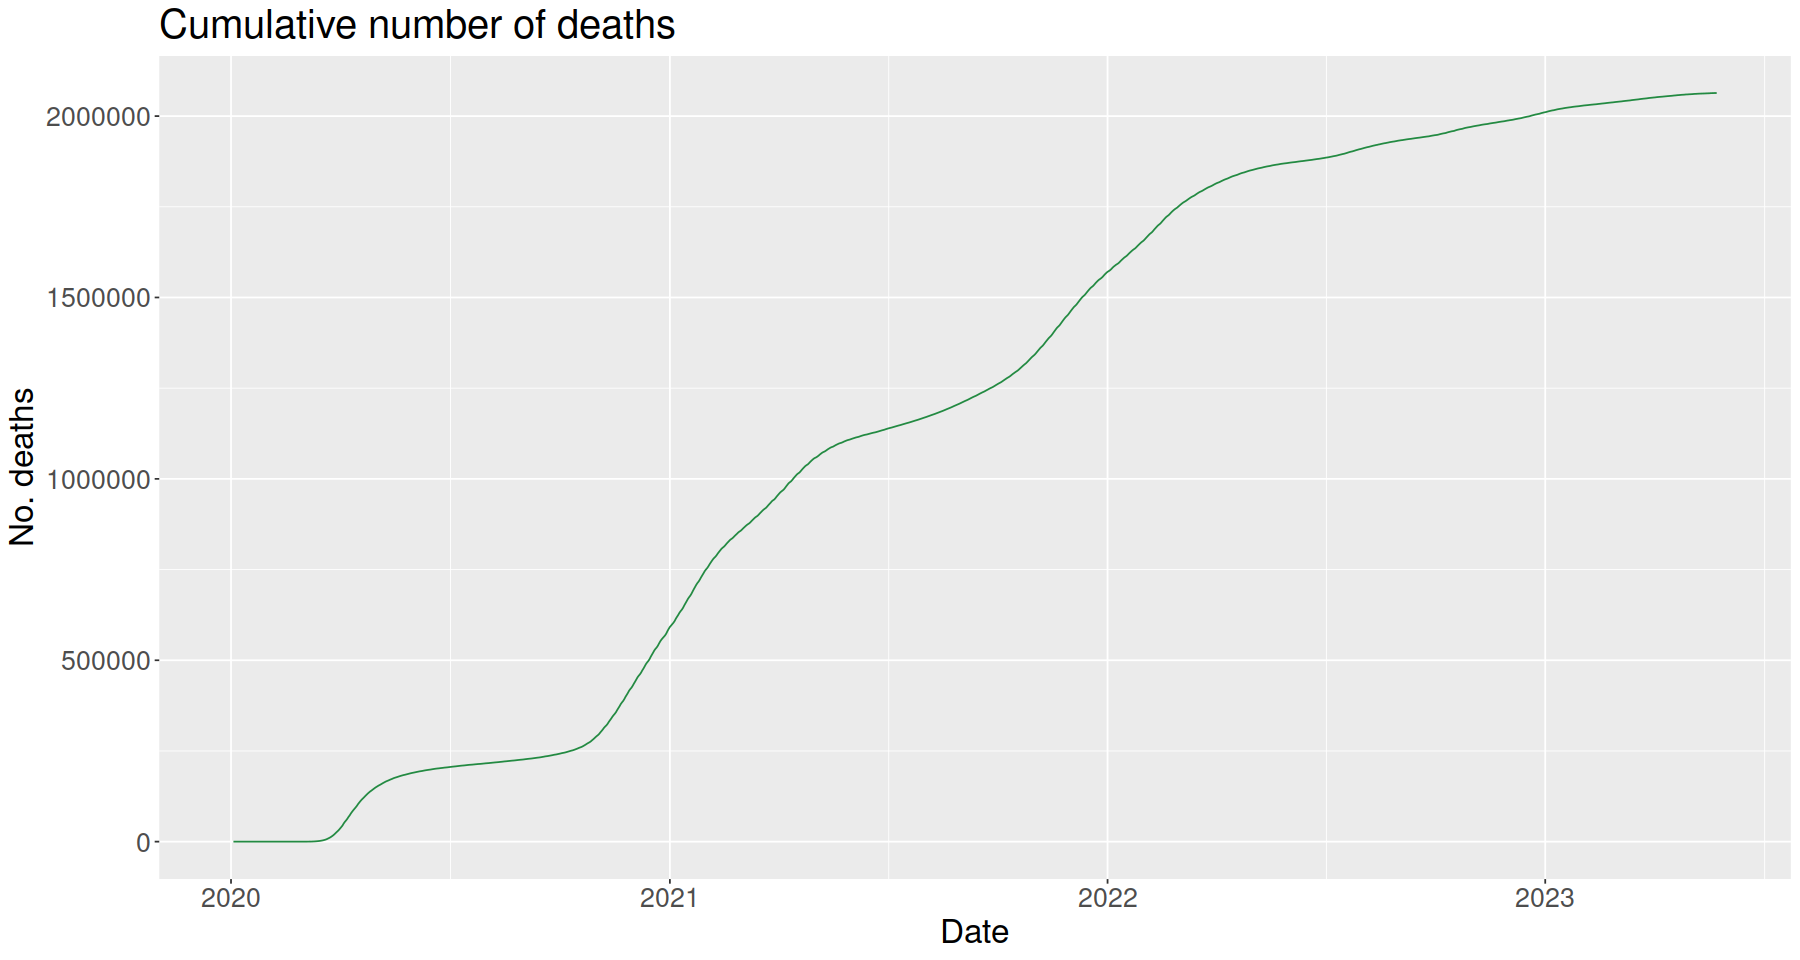

In [33]:
# deaths cumulative, method 1
cumndeaths_europe_tbl = owid_dataset %>%
        filter(continent == 'Europe') %>% 
        select(date, new_deaths) %>% 
        drop_na() %>%
        mutate(date = as_date(date)) %>%
        group_by(date) %>% 
        summarize(daily_new_deaths = sum(new_deaths)) %>% 
        mutate(cum_new_deaths = cumsum(daily_new_deaths))
head(cumndeaths_europe_tbl)

p10 = ggplot(data = cumndeaths_europe_tbl) + geom_line(aes(x = date, y = cum_new_deaths), colour = '#238a42') +
        labs(x = 'Date', y = 'No. deaths', title = 'Cumulative number of deaths') +
        theme(text = element_text(size = 20))
p10

Summarize Global Plots

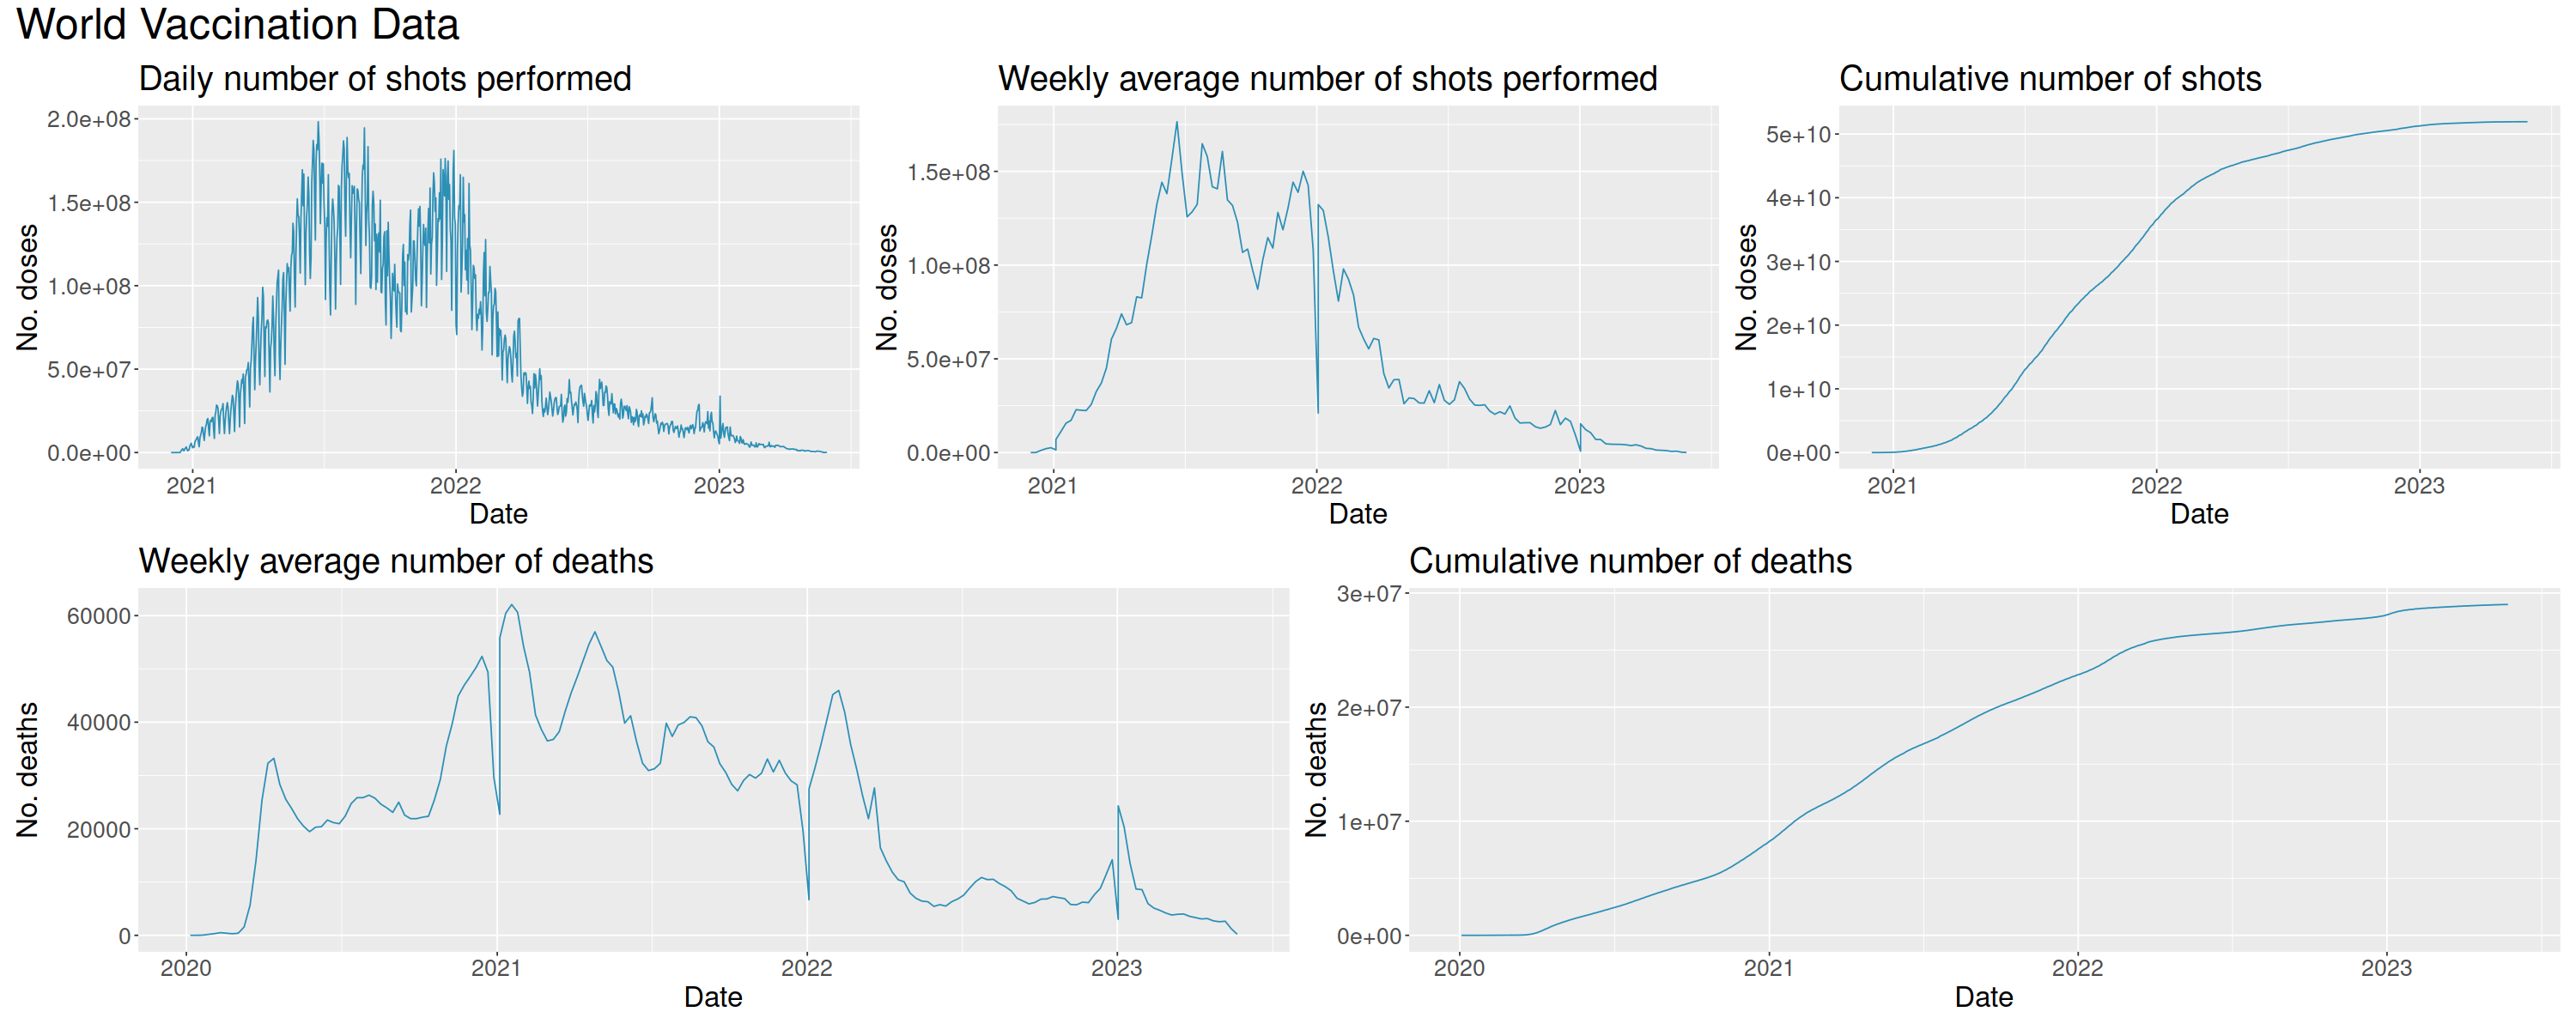

In [34]:
library(patchwork)
options(repr.plot.width=25, repr.plot.height=10)
p_glob = (p1 | p2 | p3) / (p4 | p5) + plot_annotation(title = 'World Vaccination Data', theme = theme(plot.title = element_text(size = 30))) 
p_glob

Summarize Europe Plots

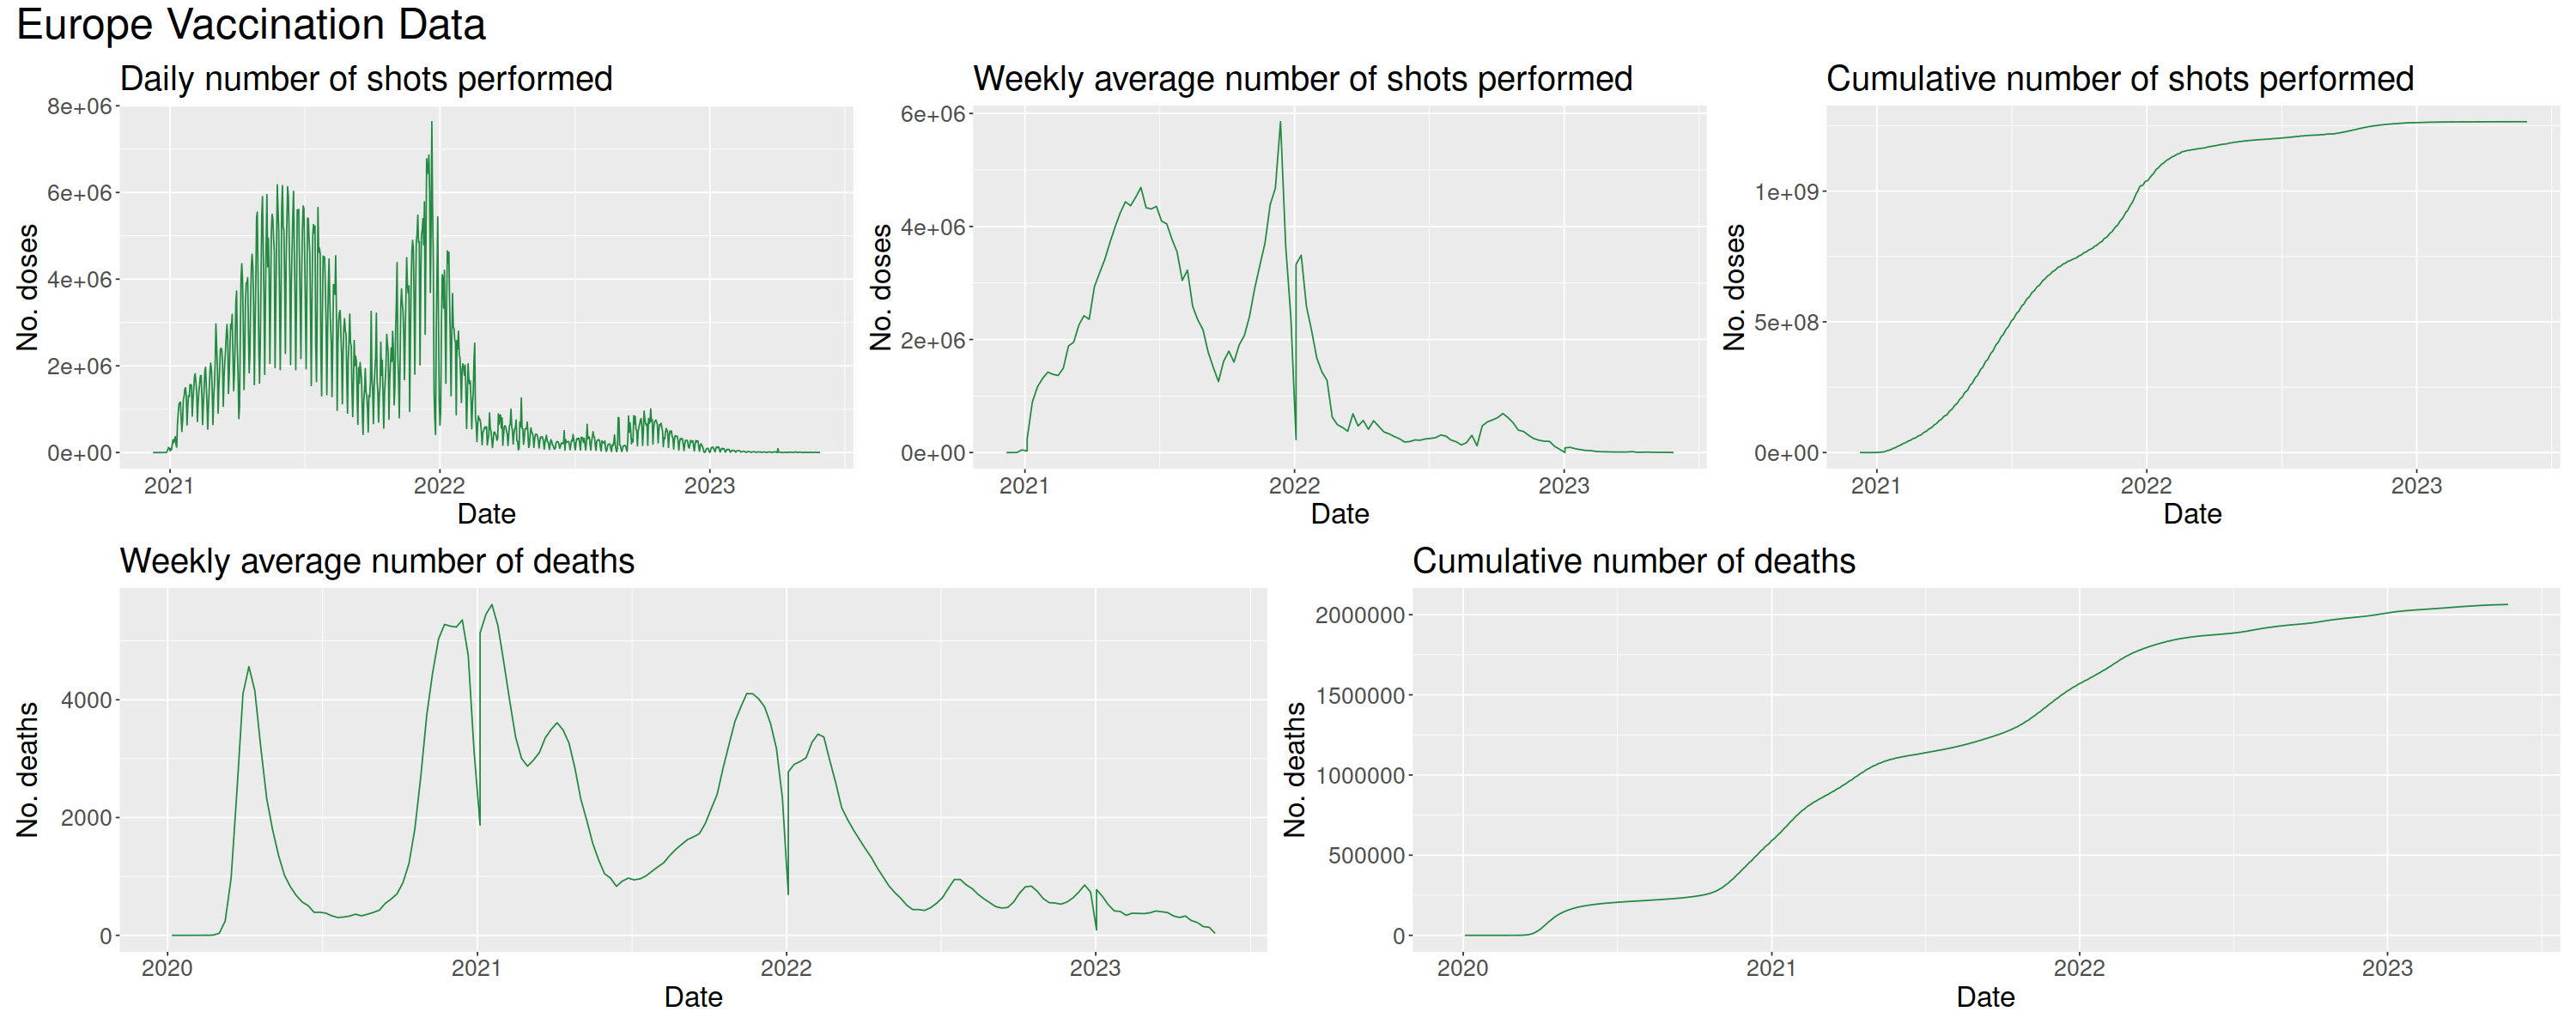

In [35]:
library(patchwork)
options(repr.plot.width=25, repr.plot.height=10)
p_glob = (p6 | p7 | p8) / (p9 | p10) + plot_annotation(title = 'Europe Vaccination Data', theme = theme(plot.title = element_text(size = 30))) 
p_glob